# Generating Distractors for Questions

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

from datetime import datetime

# Exploratory Data Analysis

## Data Loading and Cleaning

In [2]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=11)

In [3]:
df = pd.read_csv('Train.csv')

print("Number of data points:",df.shape[0])

Number of data points: 31499


In [4]:
df.head()

,question,answer_text,distractor
0,Meals can be served,in rooms at 9:00 p. m.,"'outside the room at 3:00 p. m.', 'in the dini..."
1,It can be inferred from the passage that,The local government can deal with the problem...,"'If some tragedies occur again ', ' relevant d..."
2,The author called Tommy 's parents in order to,help them realize their influence on Tommy,"'blame Tommy for his failing grades', 'blame T..."
3,It can be inferred from the passage that,the writer is not very willing to use idioms,'idioms are the most important part in a langu...
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,'Cut the wound and suck the poison out .'


## Count the number of distractor per question

In [5]:
start = datetime.now()
df["distractor_count"] = df["distractor"].apply(lambda text: len(text.split(",")))

# adding a new feature number of distractor per question
print("Time taken to run this cell :", datetime.now() - start)

df.head()

Time taken to run this cell : 0:00:00.017965


,question,answer_text,distractor,distractor_count
0,Meals can be served,in rooms at 9:00 p. m.,"'outside the room at 3:00 p. m.', 'in the dini...",3
1,It can be inferred from the passage that,The local government can deal with the problem...,"'If some tragedies occur again ', ' relevant d...",5
2,The author called Tommy 's parents in order to,help them realize their influence on Tommy,"'blame Tommy for his failing grades', 'blame T...",2
3,It can be inferred from the passage that,the writer is not very willing to use idioms,'idioms are the most important part in a langu...,3
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,'Cut the wound and suck the poison out .',1


In [6]:
df.distractor_count.value_counts()

3     11657
1      9151
2      8753
4      1219
5       318
6       290
7        41
8        26
9        23
12       10
10        7
15        2
29        1
11        1
Name: distractor_count, dtype: int64

## Droping the rows which have more than 4 distractors

In [7]:
df.drop(df[df['distractor_count'] > 4].index, inplace = True)
df.distractor_count.value_counts()

3    11657
1     9151
2     8753
4     1219
Name: distractor_count, dtype: int64

In [8]:
df.shape

(30780, 4)

In [9]:
df.head()

,question,answer_text,distractor,distractor_count
0,Meals can be served,in rooms at 9:00 p. m.,"'outside the room at 3:00 p. m.', 'in the dini...",3
2,The author called Tommy 's parents in order to,help them realize their influence on Tommy,"'blame Tommy for his failing grades', 'blame T...",2
3,It can be inferred from the passage that,the writer is not very willing to use idioms,'idioms are the most important part in a langu...,3
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,'Cut the wound and suck the poison out .',1
5,What was the writer 's problem when she studie...,She missed her family very much .,"""She did n't like her new school ."", ""She did ...",3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30780 entries, 0 to 31498
Data columns (total 4 columns):
question            30780 non-null object
answer_text         30780 non-null object
distractor          30780 non-null object
distractor_count    30780 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


## Cleaning Data

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
df['distractor'] = df['distractor'].apply(lambda x: clean_text(x))

### Checking missing value

Text(0.5, 1.0, 'Ratio of missing values per columns')

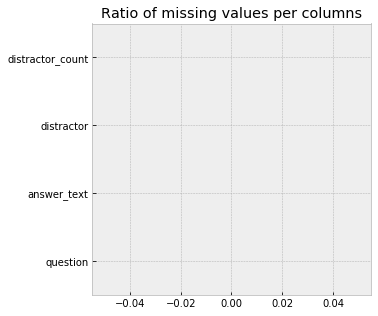

In [13]:
plt.figure(figsize=(5, 5))
df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

## Checking Duplicate Entries

In [14]:
print('Dupplicate entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Dupplicate entries: 0


This is a very good dataset since there are no missing valeus or dupplicate values

# Analysis of Distractors

### Taking distractors data to analyse and visualise it

In [15]:
distractor_data = pd.DataFrame(zip(df.distractor, df.distractor_count),columns=['distractor', 'distractor_count'])
distractor_data.head()

,distractor,distractor_count
0,"'outside the room at 3:00 p. m.', 'in the dini...",3
1,"'blame tommy for his failing grades', 'blame t...",2
2,'idioms are the most important part in a langu...,3
3,'cut the wound and suck the poison out .',1
4,"""she did not like her new school ."", ""she did ...",3


## Count how many distractors are there

In [16]:
df['distractor'] = df['distractor'].apply(lambda x: x.split(','))
all_distractors = [item for sublist in df['distractor'].values for item in sublist]
len(all_distractors)

66504

In [17]:
df.shape

(30780, 4)

## Count how many Unique distractors are there

In [18]:
my_set = set(all_distractors)
unique_distractors = list(my_set)
len(unique_distractors)

65382

## Visualisation of first 20 distractor

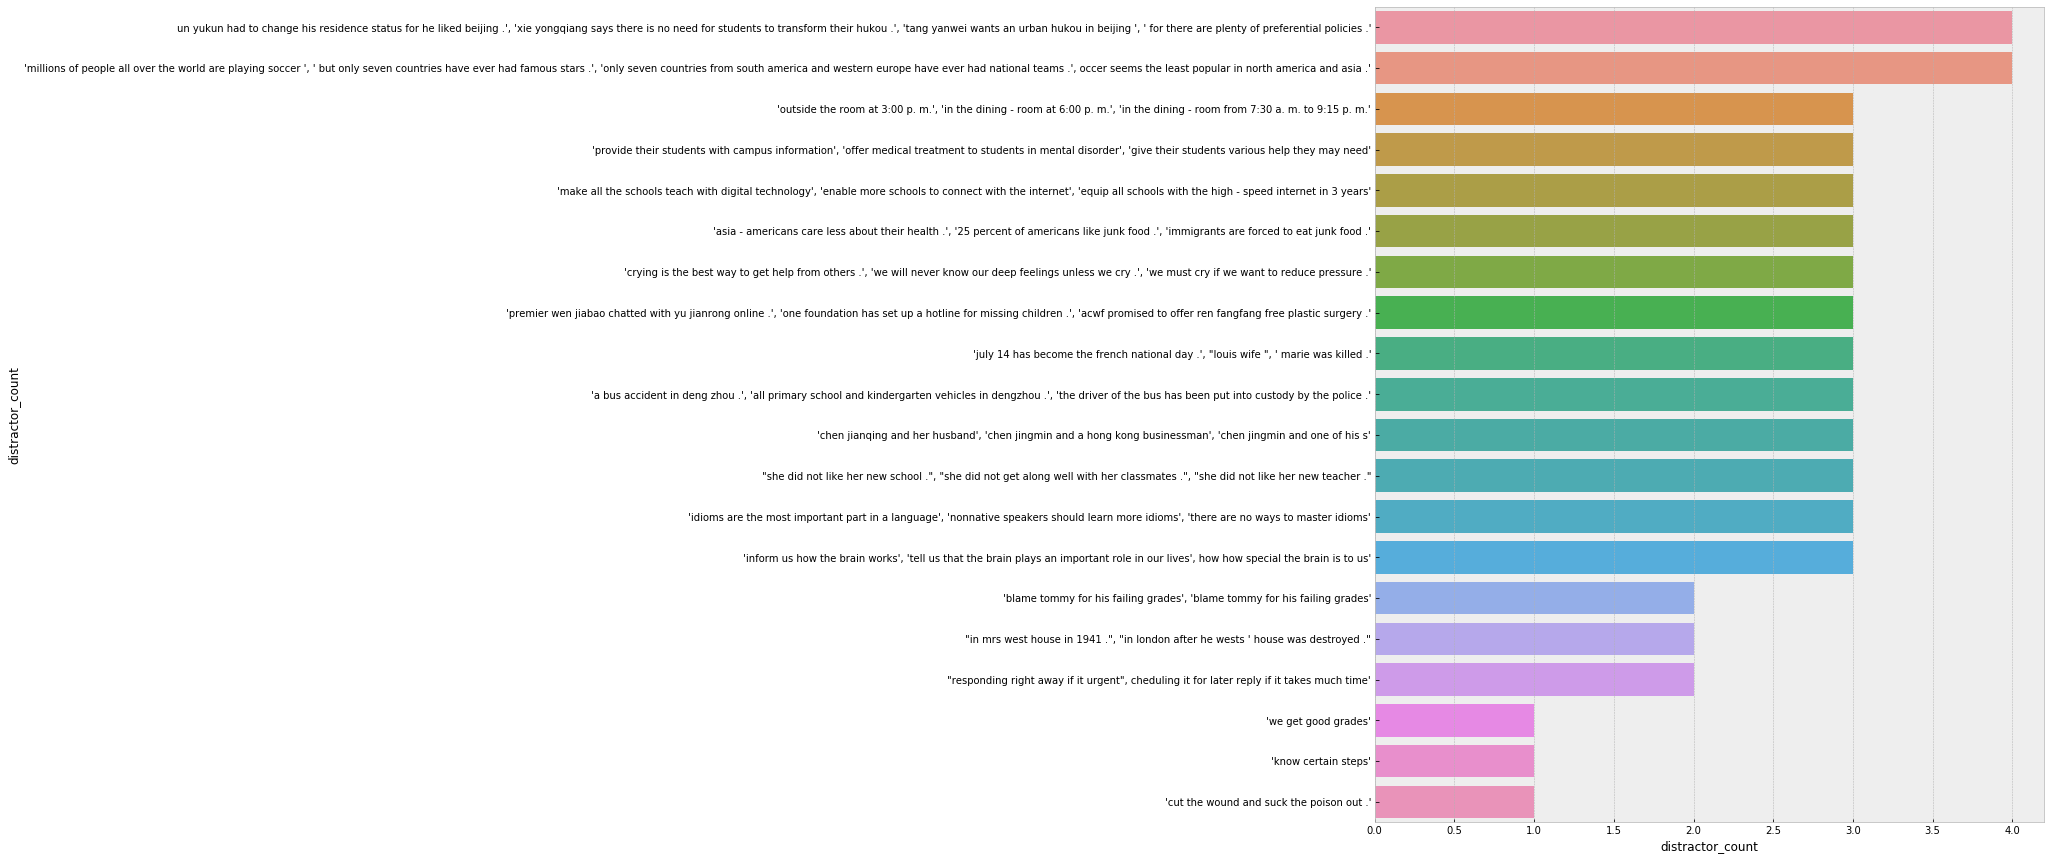

In [19]:
g = distractor_data[:20].nlargest(columns="distractor_count", n = 50) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "distractor_count", y = "distractor")
ax.set(ylabel = 'distractor_count')
plt.show()

## Total number of unique distractors using CountVectorizer

In [20]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
distractor_dtm = vectorizer.fit_transform(distractor_data['distractor'])

In [21]:
type(distractor_dtm)

scipy.sparse.csr.csr_matrix

In [22]:
distractor_dtm.shape

(30780, 65382)

In [23]:
print("Number of data points :", distractor_dtm.shape[0])
print("Number of unique distractors :", distractor_dtm.shape[1])

Number of data points : 30780
Number of unique distractors : 65382


In [24]:
#'get_feature_name()' gives us the vocabulary.
distractors = vectorizer.get_feature_names()
#Lets look at the distractors we have.
print("Some of the distractors we have :", distractors[:10])

Some of the distractors we have : [' " 329 flights were put off at the capital airport ."', ' " 500 people died on titanic maiden voyage in 1912 ."', ' " a blind man need not do anything ."', ' " aids and parkinson disease ."', ' " alan did not realize the fact until years later"', ' " and you will have more time to study ."', ' " apple iphone 6 is thinner and lighter ."', ' " as it no use doing it individually"', ' " beauty is not a must ."', ' " because he does not want any food ."']


In [25]:
while(' ' in distractors) : 
    distractors.remove(' ')
distractors = list(filter(None, distractors))
distractors

[' " 329 flights were put off at the capital airport ."',
 ' " 500 people died on titanic maiden voyage in 1912 ."',
 ' " a blind man need not do anything ."',
 ' " aids and parkinson disease ."',
 ' " alan did not realize the fact until years later"',
 ' " and you will have more time to study ."',
 ' " apple iphone 6 is thinner and lighter ."',
 ' " as it no use doing it individually"',
 ' " beauty is not a must ."',
 ' " because he does not want any food ."',
 ' " because we ca not live without water"',
 ' " but did not say it out"',
 ' " but he could not find all the goods on the list"',
 ' " but he did not remember any of their names"',
 ' " but it ca not let you down ."',
 ' " but male mangers do not respect female workers ."',
 ' " but miss white had not realized it at first ."',
 ' " but now it turned into milky white gradually ."',
 ' " but now they do not ."',
 ' " but she does not know how to socialize"',
 ' " but she is not my favorite teacher"',
 ' " but some people fidgeti

## Number of times a distractors appeared

In [26]:
#store the document term matrix in a dictionary.
freqs = distractor_dtm.sum(axis=0).A1
result = dict(zip(distractors, freqs))

In [27]:
result

{' " 329 flights were put off at the capital airport ."': 1,
 ' " 500 people died on titanic maiden voyage in 1912 ."': 1,
 ' " a blind man need not do anything ."': 1,
 ' " aids and parkinson disease ."': 1,
 ' " alan did not realize the fact until years later"': 1,
 ' " and you will have more time to study ."': 1,
 ' " apple iphone 6 is thinner and lighter ."': 1,
 ' " as it no use doing it individually"': 1,
 ' " beauty is not a must ."': 1,
 ' " because he does not want any food ."': 1,
 ' " because we ca not live without water"': 1,
 ' " but did not say it out"': 1,
 ' " but he could not find all the goods on the list"': 1,
 ' " but he did not remember any of their names"': 1,
 ' " but it ca not let you down ."': 1,
 ' " but male mangers do not respect female workers ."': 1,
 ' " but miss white had not realized it at first ."': 1,
 ' " but now it turned into milky white gradually ."': 1,
 ' " but now they do not ."': 2,
 ' " but she does not know how to socialize"': 1,
 ' " but sh

In [28]:
import os
import csv
#Saving this dictionary to csv files.
if not os.path.isfile('distractors_counts_dict.csv'):
    with open('distractors_counts_dict.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
distractor_df = pd.read_csv("distractors_counts_dict.csv", names=['distractor', 'distractor_Counts'])
distractor_df.head()

,distractor,distractor_Counts
0,""" 329 flights were put off at the capital air...",1
1,""" 500 people died on titanic maiden voyage in...",1
2,""" a blind man need not do anything .""",1
3,""" aids and parkinson disease .""",1
4,""" alan did not realize the fact until years l...",1


In [29]:
len(distractor_df)

65382

### Sorting distractor_counts into ascending order

In [30]:
distractor_df_sorted = distractor_df.sort_values(['distractor_Counts'], ascending=False)
distractor_df_sorted.head()

,distractor,distractor_Counts
6517,'',42
6256,' too .',11
6257,' too',9
39580,'a friend in need is a friend indeed',8
52105,'no ',6


In [31]:
distractor_df_sorted.drop(distractor_df_sorted[distractor_df_sorted['distractor_Counts'] == 42].index, inplace = True)
distractor_df_sorted.head()

,distractor,distractor_Counts
6256,' too .',11
6257,' too',9
39580,'a friend in need is a friend indeed',8
52105,'no ',6
48396,'in fact ',6


In [32]:
distractor_counts = distractor_df_sorted['distractor_Counts'].values
distractor_counts

array([11,  9,  8, ...,  1,  1,  1], dtype=int64)

In [33]:
# len(distractor_counts)

## Visualisation for distractor how many times appeared for the questions

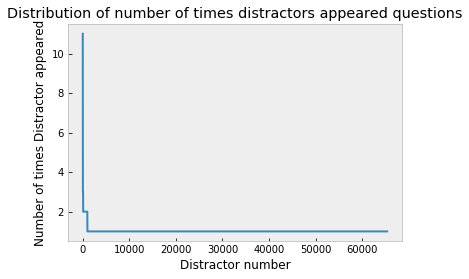

In [34]:
plt.plot(distractor_counts)
plt.title("Distribution of number of times distractors appeared questions")
plt.grid()
plt.xlabel("Distractor number")
plt.ylabel("Number of times Distractor appeared")
plt.show()
# it will show steepness in the curve it will droppig very steeply. It is coming down so fast. 
# so have to reduce the distractor to see the smoothness of the curve.

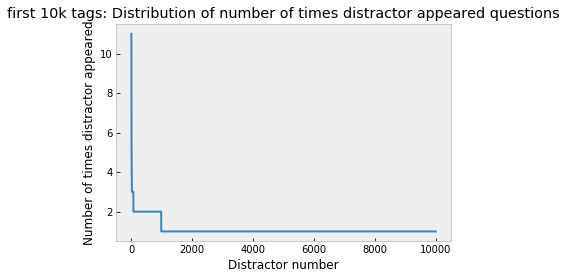

400 [11  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

In [35]:
# using 10000 distractor 
# still it is drooping very steeply but a little smoothness has came.
plt.plot(distractor_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times distractor appeared questions')
plt.grid()
plt.xlabel("Distractor number")
plt.ylabel("Number of times distractor appeared")
plt.show()
print(len(distractor_counts[0:10000:25]), distractor_counts[0:10000:25])

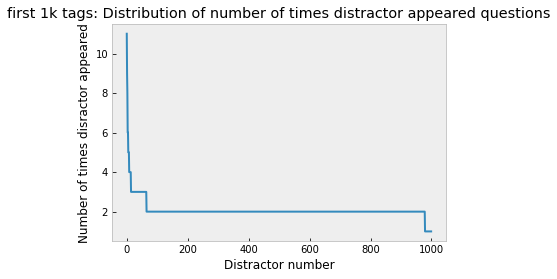

200 [11  5  4  3  3  3  3  3  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  1  1  1  1]


In [36]:
# using 1000 distractor 
# still it is drooping very steeply but a little more n more smoothness has came.

plt.plot(distractor_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times distractor appeared questions')
plt.grid()
plt.xlabel("Distractor number")
plt.ylabel("Number of times disractor appeared")
plt.show()
print(len(distractor_counts[0:1000:5]), distractor_counts[0:1000:5])

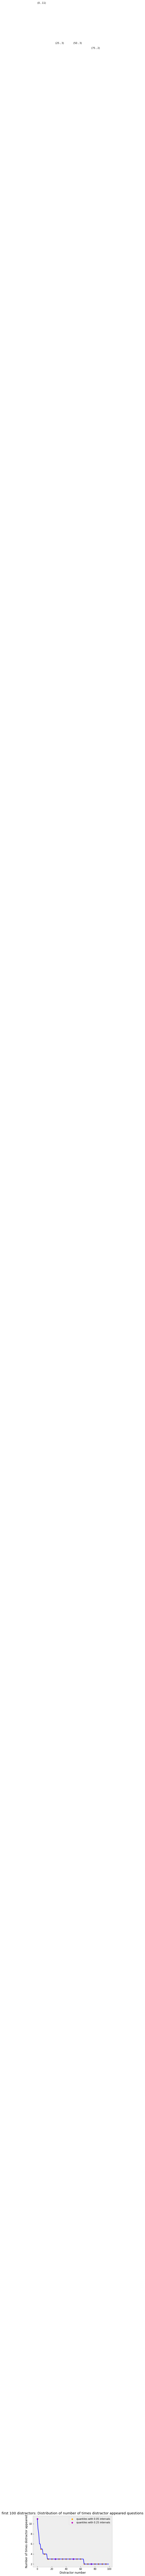

20 [11  5  4  3  3  3  3  3  3  3  3  3  3  2  2  2  2  2  2  2]


In [37]:
#  this time i have use top 100 distractor which is in decending order in order to make more meaning out of it.
#  I have put contile like that means yellow color that is 5th percentile and so on.
#  this help in reading the graph and see that after dropping that is preety close.

plt.plot(distractor_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=distractor_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=distractor_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), distractor_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 distractors: Distribution of number of times distractor appeared questions')
plt.grid()
plt.xlabel("Distractor number")
plt.ylabel("Number of times distractor appeared")
plt.legend()
plt.show()
print(len(distractor_counts[0:100:5]), distractor_counts[0:100:5])

In [38]:
# Store distractors greater than 10K in one list
lst_distractors_gt_1k = distractor_df[distractor_df.distractor_Counts>1].distractor

#Print the length of the list
print ('{} Distractors are used more than 1 times'.format(len(lst_distractors_gt_1k)))

# Store tags greater than 100K in one list
lst_distractors_gt_10k = distractor_df[distractor_df.distractor_Counts>3].distractor

#Print the length of the list.
print ('{} Distractors are used more than 3 times'.format(len(lst_distractors_gt_10k)))

# In this we observe 980 Distractors are used more than 1 times
# 15 Distractors are used more than 3 times
# in this case we observe some distractor have occur very high some occur very low.
# so in this case micro f1-score will make more sense

980 Distractors are used more than 1 times
15 Distractors are used more than 3 times


## Distractors Per Question

In [39]:
#Storing the count of tag in each question in list 'tag_count'
distractor_quest_count = distractor_dtm.sum(axis=1).tolist()

#Converting each value in the 'tag_quest_count' to integer.
distractor_quest_count=[int(j) for i in distractor_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(distractor_quest_count)))

print(distractor_quest_count[:10])

We have total 30780 datapoints.
[3, 2, 3, 1, 3, 3, 4, 1, 3, 1]


In [40]:
print( "Maximum number of distractors per question: %d"%max(distractor_quest_count))
print( "Minimum number of distractors per question: %d"%min(distractor_quest_count))
print( "Avg. number of distractors per question: %f"% ((sum(distractor_quest_count)*1.0)/len(distractor_quest_count)))

# more analysys on distractor while printing it automatically knw.

Maximum number of distractors per question: 4
Minimum number of distractors per question: 1
Avg. number of distractors per question: 2.160624


<b>Observations:</b><br />
1. Maximum number of Distractors per question: 4
2. Minimum number of Distractors per question: 1
3. Avg. number of Distractors per question: 2.160624
4. Most of the questions are having 1 or 2 or 3 Distractors

## Most Frequent Distractors using Word cloud

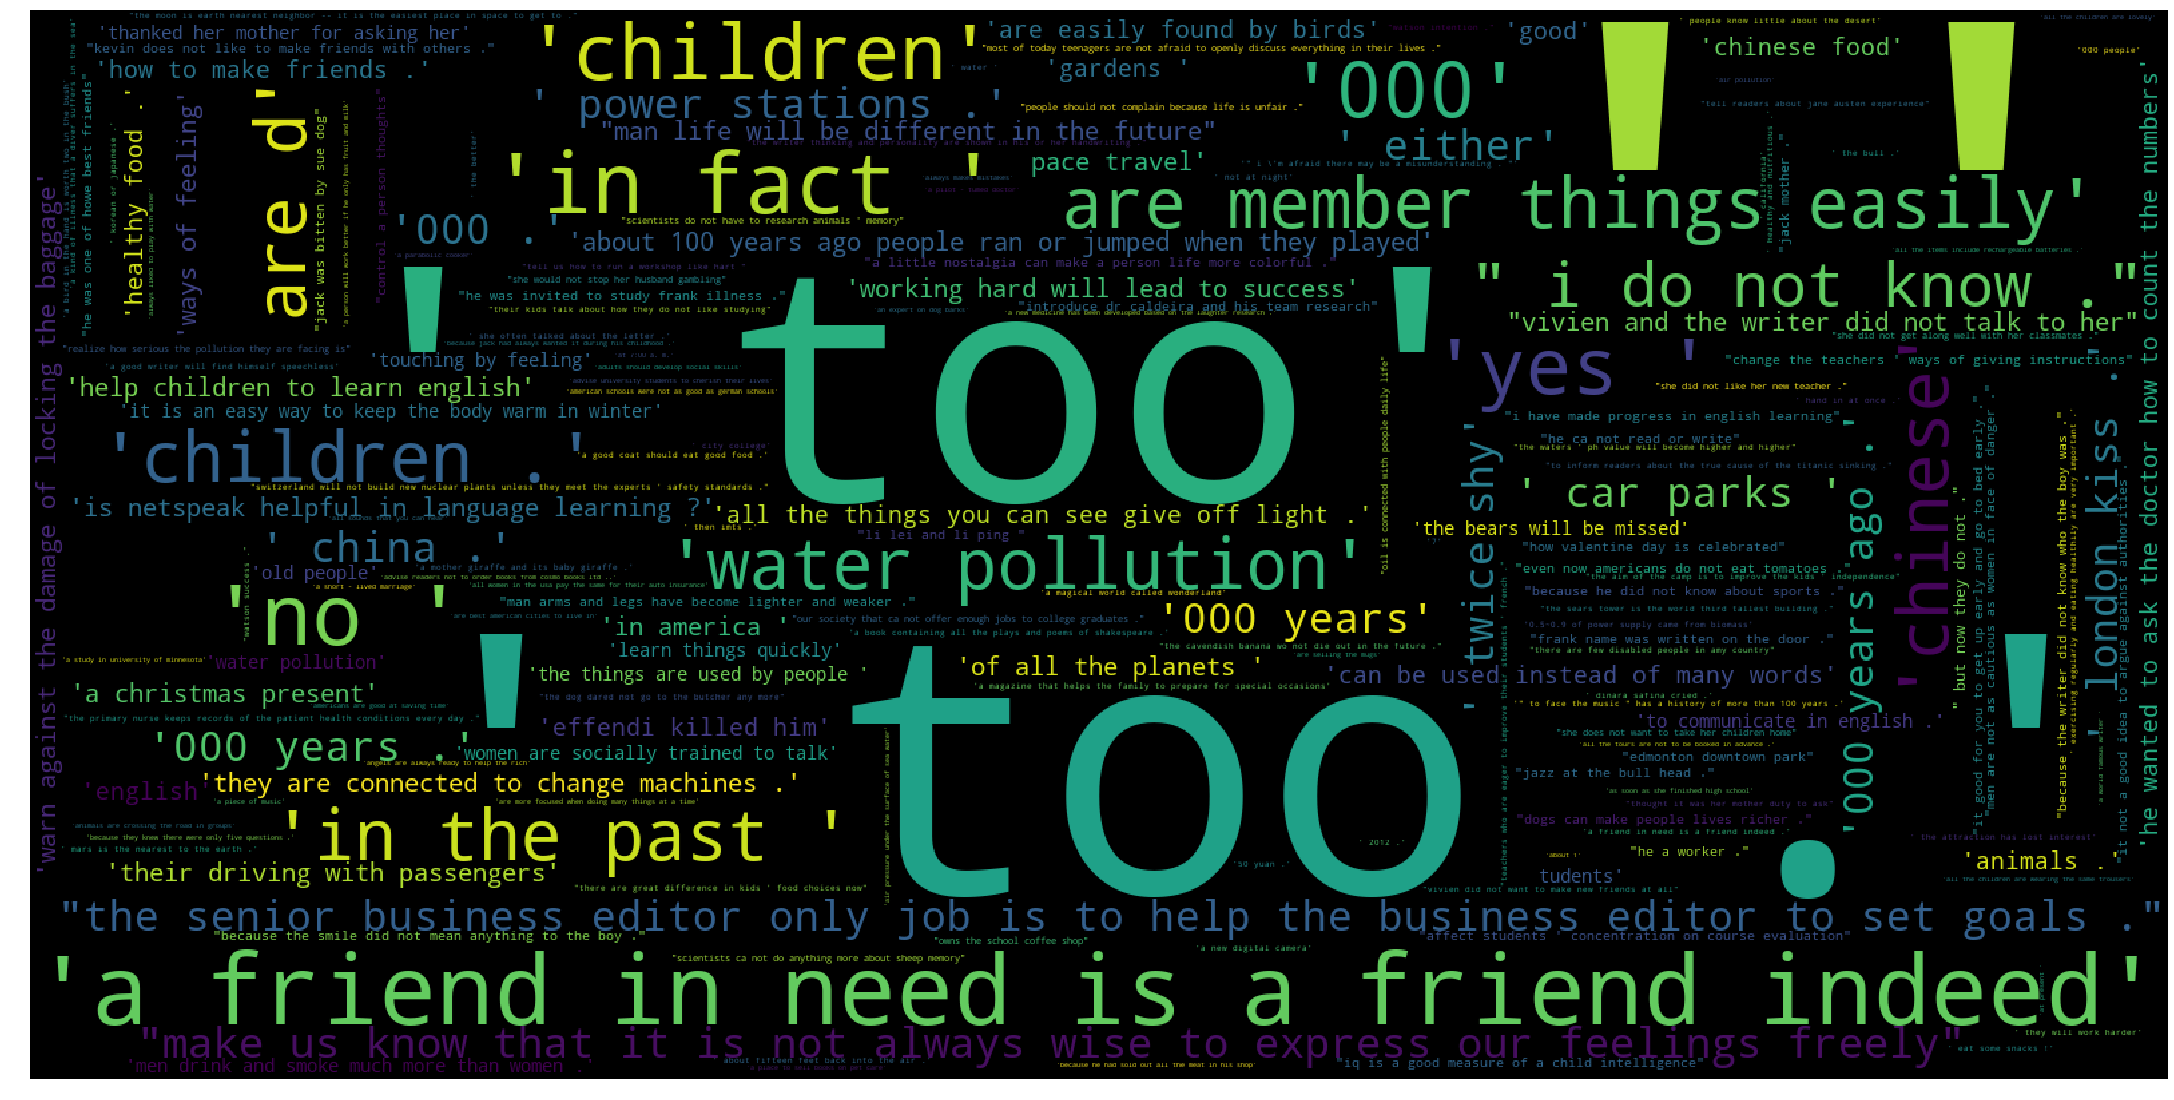

Time taken to run this cell : 0:00:04.970962


In [41]:
# Ploting word cloud
from wordcloud import WordCloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("distractor.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

# in wordcloud the bigger the size of word is occur more number of times. here I can analyse it which distractor has been
# used frequently

## The top 20 Distractors

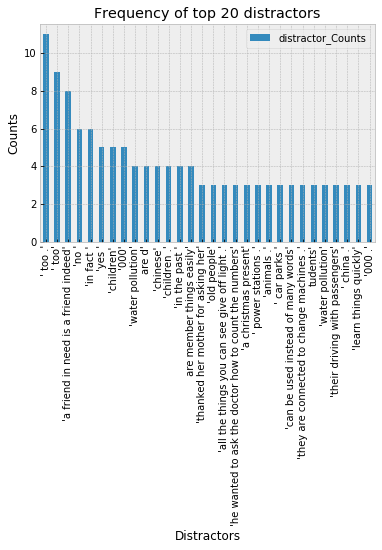

In [42]:
i=np.arange(30)
distractor_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 distractors')
plt.xticks(i, distractor_df_sorted['distractor'])
plt.xlabel('Distractors')
plt.ylabel('Counts')
plt.show()

# plotting highest distractor in the bar graph and came to know how many times it occur.

## Getting the Frequency of the words and sentences 

In [43]:
flat_list = [item for sublist in df['distractor'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(10000)
distractors_features = [word[0] for word in frequencies_words]

## Getting the features of distractors with most common

In [44]:
distractors_features = distractors_features[2:]
distractors_features

[" ' too'",
 "'a friend in need is a friend indeed'",
 "'in fact '",
 "'no '",
 "'yes '",
 " '000'",
 "'children'",
 " 'water pollution'",
 "are d'",
 " 'in the past '",
 "'children .'",
 "'chinese'",
 " are member things easily'",
 " ' twice shy'",
 " '000 years ago .'",
 " 'warn against the damage of locking the baggage'",
 "'english'",
 " pace travel'",
 "'women are socially trained to talk'",
 " 'about 100 years ago people ran or jumped when they played'",
 " ' london kiss .'",
 "'old people'",
 '"man life will be different in the future"',
 "'touching by feeling'",
 " 'ways of feeling'",
 "'the bears will be missed'",
 " ' china .'",
 "'are easily found by birds'",
 "'how to make friends .'",
 " ' either'",
 " '000 .'",
 "tudents'",
 "'effendi killed him'",
 ' " i do not know ."',
 "'water pollution'",
 " 'help children to learn english'",
 "'good'",
 " 'in america '",
 " 'their driving with passengers'",
 "'all the things you can see give off light .'",
 "'chinese food'",
 " '000

## Visualisation of the frequencies

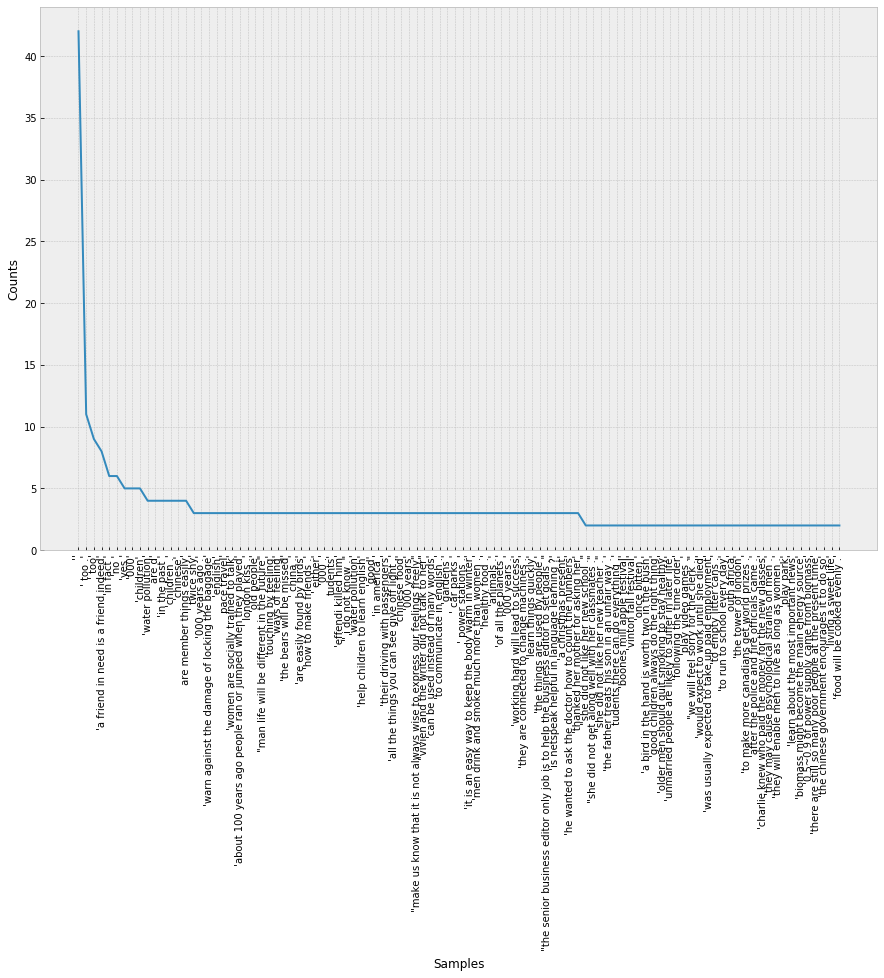

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

## Most common Distractors

In [46]:
def most_common(distractors):
    distractors_filtered = []
    for i in range(0, len(distractors)):
        if distractors[i] in distractors_features:
            distractors_filtered.append(distractors[i])
    return distractors_filtered

In [47]:
df.shape

(30780, 4)

## Number of distractor in the question question

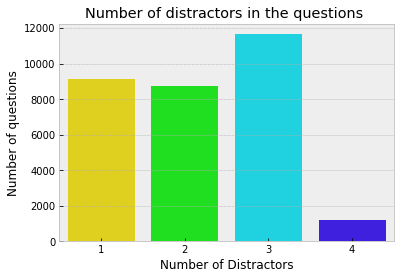

In [48]:
sns.countplot(df.distractor_count, palette='gist_rainbow')
plt.title("Number of distractors in the questions ")
plt.xlabel("Number of Distractors")
plt.ylabel("Number of questions")
plt.show()

# I obseved that the most frequent the distractor has been used is 3, 1 and 2. 

## Droping the distractor count columns

In [49]:
df.drop(columns=['distractor_count'], inplace=True)

In [50]:
df.shape

(30780, 3)

In [51]:
df.head()

,question,answer_text,distractor
0,Meals can be served,in rooms at 9:00 p. m.,"['outside the room at 3:00 p. m.', 'in the di..."
2,The author called Tommy 's parents in order to,help them realize their influence on Tommy,"['blame tommy for his failing grades', 'blame..."
3,It can be inferred from the passage that,the writer is not very willing to use idioms,['idioms are the most important part in a lang...
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,['cut the wound and suck the poison out .']
5,What was the writer 's problem when she studie...,She missed her family very much .,"[""she did not like her new school ."", ""she di..."


In [52]:
df.distractor[5]

['"she did not like her new school ."',
 ' "she did not get along well with her classmates ."',
 ' "she did not like her new teacher ."']

In [53]:
df.distractor

0        ['outside the room at 3:00 p. m.',  'in the di...
2        ['blame tommy for his failing grades',  'blame...
3        ['idioms are the most important part in a lang...
4              ['cut the wound and suck the poison out .']
5        ["she did not like her new school .",  "she di...
6        ['chen jianqing and her husband',  'chen jingm...
7        ['millions of people all over the world are pl...
8                                   ['know certain steps']
9        ['a bus accident in deng zhou .',  'all primar...
10                                  ['we get good grades']
11       ['july 14 has become the french national day ....
12       [un yukun had to change his residence status f...
13       ['premier wen jiabao chatted with yu jianrong ...
14       ['crying is the best way to get help from othe...
15       ['asia - americans care less about their healt...
16       ['make all the schools teach with digital tech...
17       ["in mrs west house in 1941 .",  "in london af.

## Getting most common distractors fron the function define

In [54]:
df['distractor'] = df['distractor'].apply(lambda x: most_common(x))
df['distractor'] = df['distractor'].apply(lambda x: x if len(x)>0 else None)

In [55]:
type(df['distractor'])

pandas.core.series.Series

In [56]:
df.shape

(30780, 3)

## Droping the distractors rows whose subset is null

In [57]:
df.dropna(subset=['distractor'], inplace=True)

In [58]:
df.shape

(5481, 3)

In [59]:
df.head()

,question,answer_text,distractor
0,Meals can be served,in rooms at 9:00 p. m.,"['outside the room at 3:00 p. m.', 'in the di..."
2,The author called Tommy 's parents in order to,help them realize their influence on Tommy,"['blame tommy for his failing grades', 'blame..."
3,It can be inferred from the passage that,the writer is not very willing to use idioms,['idioms are the most important part in a lang...
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,['cut the wound and suck the poison out .']
5,What was the writer 's problem when she studie...,She missed her family very much .,"[""she did not like her new school ."", ""she di..."


In [60]:
df.distractor

0        ['outside the room at 3:00 p. m.',  'in the di...
2        ['blame tommy for his failing grades',  'blame...
3        ['idioms are the most important part in a lang...
4              ['cut the wound and suck the poison out .']
5        ["she did not like her new school .",  "she di...
6        ['chen jianqing and her husband',  'chen jingm...
7        ['millions of people all over the world are pl...
8                                   ['know certain steps']
9        ['a bus accident in deng zhou .',  'all primar...
10                                  ['we get good grades']
11       ['july 14 has become the french national day ....
12       [un yukun had to change his residence status f...
13       ['premier wen jiabao chatted with yu jianrong ...
14       ['crying is the best way to get help from othe...
15       ['asia - americans care less about their healt...
16       ['make all the schools teach with digital tech...
17       ["in mrs west house in 1941 .",  "in london af.

## Appling NLP method to get a clean text and to vectorise it

In [61]:
token=ToktokTokenizer()

In [62]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

### Strip out list is Empty

In [64]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

### Clean Punctuations of the text

In [65]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in distractors_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

In [66]:
df['question'] = df['question'].apply(lambda x: clean_punct(x)) 

In [67]:
df.head()

,question,answer_text,distractor
0,Meals can be served,in rooms at 9:00 p. m.,"['outside the room at 3:00 p. m.', 'in the di..."
2,The author called Tommy s parents in order to,help them realize their influence on Tommy,"['blame tommy for his failing grades', 'blame..."
3,It can be inferred from the passage that,the writer is not very willing to use idioms,['idioms are the most important part in a lang...
4,How can we deal with snake wounds according to...,Stay calm and do n't move .,['cut the wound and suck the poison out .']
5,What was the writer s problem when she studied...,She missed her family very much .,"[""she did not like her new school ."", ""she di..."


### Applying the stemming, lemma and stopwords to get text more clean to vectorize

In [68]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

In [69]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

### Applying the all NLP function to each dataframe question and answer_text

In [70]:
df['question'] = df['question'].apply(lambda x: lemitizeWords(x)) 
df['question'] = df['question'].apply(lambda x: stopWordsRemove(x)) 

In [71]:
df['answer_text'] = df['answer_text'].apply(lambda x: str(x))
df['answer_text'] = df['answer_text'].apply(lambda x: clean_text(x)) 
df['answer_text'] = df['answer_text'].apply(lambda x: clean_punct(x)) 
df['answer_text'] = df['answer_text'].apply(lambda x: lemitizeWords(x)) 
df['answer_text'] = df['answer_text'].apply(lambda x: stopWordsRemove(x)) 

In [72]:
df.head()

,question,answer_text,distractor
0,Meals serve,room 9 00 p,"['outside the room at 3:00 p. m.', 'in the di..."
2,The author call Tommy parent order,help realize influence tommy,"['blame tommy for his failing grades', 'blame..."
3,It infer passage,writer use idioms,['idioms are the most important part in a lang...
4,How deal snake wound accord passage,stay calm move,['cut the wound and suck the poison out .']
5,What writer problem study board school first,miss family much,"[""she did not like her new school ."", ""she di..."


## More weightage to the answer_text so that i can improve my f1-score more.¶

In [73]:
df['text'] = df['question'] +" "+df['answer_text']+" "+df['answer_text']

In [74]:
df.text[2]

'The author call Tommy parent order help realize influence tommy help realize influence tommy'

In [75]:
print("number of data points in sample :", df.shape[0])
print("number of dimensions :", df.shape[1])

number of data points in sample : 5481
number of dimensions : 4


In [76]:
df.shape

(5481, 4)

# Machine Learning Models

## Converting distractors for Multilabel problems

In [77]:
# This problem is based on multilabel problem because the distractor is a set of the target labels.
# This can be thought as predicting properties of a data-point that are not mutually exclusive, 
# such as answer that are relevant for a question. 
# A question might be about any of religion, politics, finance or education at the same time or none of these and 
# distractor will have some options for it.

# Multi-Label some how have to convert binary or multiclass classification to make it simpler.
# that will create a OneVsRest classifier


# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','), binary='true')
multilabel_y = vectorizer.fit_transform(distractor_data['distractor'])

In [78]:
type(multilabel_y)

scipy.sparse.csr.csr_matrix

## Function for how many distractor to be choose to cover how many % of question that will cover.

In [79]:
def distractor_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_distractors_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_distractors_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = distractor_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

## Converting string Distractor to multilable output variables

In [80]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(distractor_data['distractor'])

In [81]:
questions_explained = []
total_distractors=multilabel_y.shape[1]
total_qs=distractor_data.shape[0]
for i in range(100, total_distractors, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

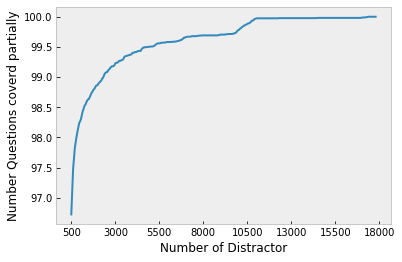

with  5500 Distractor we are covering  99.227 % of questions
with  500 Distractor we are covering  98.265 % of questions


In [82]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of Distractor")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"Distractor we are covering ",questions_explained[50],"% of questions")
print("with ",500,"Distractor we are covering ",questions_explained[10],"% of questions")

In [83]:
# we will be taking 5000 Distractor
multilabel_yx = distractor_to_choose(5000)
print("number of questions that are not covered :", questions_explained_fn(5000),"out of ", total_qs)

number of questions that are not covered : 248 out of  30780


## Featurizing data

In [84]:
no_topics = 30

In [85]:
text = df['text']

In [86]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8',
                                       smooth_idf=True, norm="l2",
                                       ngram_range=(1,3),
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [87]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [88]:
TF_IDF_matrix

<5481x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 46382 stored elements in Compressed Sparse Row format>

In [89]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [90]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
plant green cities kinds near grass earth order environment how
--------------------------------------------
--------------------------------------------
Topic 1:
book club stories nice george job conclude away well lot
--------------------------------------------
--------------------------------------------
Topic 2:
pay visit park city save special big little new watch
--------------------------------------------
--------------------------------------------
Topic 3:
infer who it infer passage place it infer worry teachers what infer baby
--------------------------------------------
--------------------------------------------
Topic 4:
word ability often treat store farmer fire mean ill difference
--------------------------------------------
--------------------------------------------
Topic 5:
hand sentence follow sentence which follow sentence hurt which follow follow which get people
--------------------------------------------
-

#  Classical classifiers

In [91]:
X1 = df['answer_text']
X2 = df['question']
# X3 = df.text
y = df['distractor']

In [92]:
type(y)

pandas.core.series.Series

In [93]:
y

0        ['outside the room at 3:00 p. m.',  'in the di...
2        ['blame tommy for his failing grades',  'blame...
3        ['idioms are the most important part in a lang...
4              ['cut the wound and suck the poison out .']
5        ["she did not like her new school .",  "she di...
6        ['chen jianqing and her husband',  'chen jingm...
7        ['millions of people all over the world are pl...
8                                   ['know certain steps']
9        ['a bus accident in deng zhou .',  'all primar...
10                                  ['we get good grades']
11       ['july 14 has become the french national day ....
12       [un yukun had to change his residence status f...
13       ['premier wen jiabao chatted with yu jianrong ...
14       ['crying is the best way to get help from othe...
15       ['asia - americans care less about their healt...
16       ['make all the schools teach with digital tech...
17       ["in mrs west house in 1941 .",  "in london af.

In [94]:
df

,question,answer_text,distractor,text
0,Meals serve,room 9 00 p,"['outside the room at 3:00 p. m.', 'in the di...",Meals serve room 9 00 p room 9 00 p
2,The author call Tommy parent order,help realize influence tommy,"['blame tommy for his failing grades', 'blame...",The author call Tommy parent order help realiz...
3,It infer passage,writer use idioms,['idioms are the most important part in a lang...,It infer passage writer use idioms writer use ...
4,How deal snake wound accord passage,stay calm move,['cut the wound and suck the poison out .'],How deal snake wound accord passage stay calm ...
5,What writer problem study board school first,miss family much,"[""she did not like her new school ."", ""she di...",What writer problem study board school first m...
6,Who kill February 5 small town near Johannesburg,chen jianqing one partner,"['chen jianqing and her husband', 'chen jingm...",Who kill February 5 small town near Johannesbu...
7,According writer follow statements true,soccer popular world truly great players,['millions of people all over the world are pl...,According writer follow statements true soccer...
8,During fire children often,panic,['know certain steps'],During fire children often panic panic
9,What title passage,five children die kindergarten bus accident,"['a bus accident in deng zhou .', 'all primar...",What title passage five children die kindergar...
10,We feel unhappy,fight classmates,['we get good grades'],We feel unhappy fight classmates fight classmates


## MultiLabelBinarizer method has been used

In [95]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

## Featurizing the data using TfidfVectorizer method

In [96]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8',
                                       smooth_idf=True, norm="l2",
                                       ngram_range=(1,3),
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [97]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X1.fit_transform(X2)

In [98]:
type(X1_tfidf)

scipy.sparse.csr.csr_matrix

In [99]:
X1_tfidf.shape

(5481, 1000)

### hstack() function is used to stack arrays in sequence horizontally (column wise)

In [100]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [101]:
type(X_tfidf)

scipy.sparse.coo.coo_matrix

In [102]:
type(X_tfidf)

scipy.sparse.coo.coo_matrix

## Split the clean dataset into 80:20 traing and testing dataset

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

In [104]:
type(X_train.shape[0])

int

In [105]:
type(X1)

pandas.core.series.Series

In [106]:
df.question

0                                              Meals serve
2                       The author call Tommy parent order
3                                         It infer passage
4                      How deal snake wound accord passage
5             What writer problem study board school first
6         Who kill February 5 small town near Johannesburg
7                  According writer follow statements true
8                               During fire children often
9                                       What title passage
10                                         We feel unhappy
11                              What NOT effect Revolution
12                                      What infer passage
13             Which follow statements TRUE accord passage
14                 According author follow statements TRUE
15                                        According survey
16                            The purpose Connected Future
17                            When writer first meet Fra

### Get the Test question and answer for analysing with predicted distractors

In [107]:
ques_test2 = df.question[X_train.shape[0]:].tolist()
ques_test2

['When Bill fell way home Mark',
 'What learn passage',
 'Which follow author probably favor',
 'The reason author use power walk example mainly',
 'According passage find',
 'Which NOTthe convenience Medical Center provide',
 'According Robert Foss high death rate teenage drivers mainly due',
 'From passage know begin project',
 'Which follow true accord article',
 'In Walter Murch7S opinion 3D movies',
 'What main idea passage',
 'Which follow NOT true accord text',
 'The woman story',
 'According passage people read follow except',
 'For Christians important thing Easter',
 'Which kind dog easy teach',
 'Which follow NOT true accord passage',
 'We tell average family about1990',
 'Why could n writer find job big radio station',
 'We may infer Amy story',
 'It know passage',
 'Which statement true',
 'Many teenagers picture football star',
 'Why old man ask waiter take fish horse Because',
 'According passage infer',
 'According passage statement future likely true',
 'According pass

In [108]:
ans_test2 = df.answer_text[X_train.shape[0]:].tolist()
ans_test2

['help pick things',
 'laugh one mean communication',
 'cycle around lake',
 'use fewer resources',
 'instruct farmers spray',
 'nursery newly - bear baby',
 'lack drive experience',
 'nobody support except family friends',
 'immune system brain system use consider separate isolate systems',
 'unsuitable people watch',
 'key enough time improve work quality',
 'skyfall last film 007 series',
 'orange skin',
 'real news',
 'go church celebrate jesus surrection',
 'young dog',
 'people regularly eat fish never suffer heart disease',
 'four five children die five',
 'much experience',
 'news media play key role help amy',
 'two ways contact camp',
 'space vegetables belong genetically modify food extent',
 'b c',
 'want sit fire able first',
 'junk food lead childhood obesity',
 'future people able learn news source',
 'items top rack cook faster',
 'kid may see better play outside',
 'manage dixie p1 program kenton county',
 'ca avoid make mistake',
 'logical think ability',
 'nervous fi

In [109]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [110]:
X_test.shape

(1097, 2000)

In [111]:
y_train.shape

(4384, 9998)

In [112]:
y_test.shape

(1097, 9998)

# One vs Rest

In [113]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    

## Different Algorithms has been used with there scores to find out which one is best over the rest.

### To evaluate our models, I'll use the jacard score since it's the best fitted for multi label classification.

In [114]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
rfc = RandomForestClassifier()
mlpc = MLPClassifier()
lp = LabelPowerset(LogisticRegression())
br = BinaryRelevance(GaussianNB())

#  dummy, lr, mn,rfc, mlpc, lp, br 
# the above algorithm which I have commented doesnt give high score as compare to the belows algorithms which takes
# lot of times to run so I mark as comment.
for classifier in [sgd, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  SGDClassifier
Jacard score: 5.165603160133698
Hamming loss: 0.019657532235708763
---
Clf:  LinearSVC
Jacard score: 9.525979945305378
Hamming loss: 0.018791360824580595
---
Clf:  Perceptron
Jacard score: 5.005980375289016
Hamming loss: 0.10187999313627538
---
Clf:  PassiveAggressiveClassifier
Jacard score: 11.52385293223944
Hamming loss: 0.02066046755385717
---


## GridSearch CV on the best classifier

In [115]:
param_grid = {'estimator__C':[1,10,100,1000]}

In [116]:

svc = OneVsRestClassifier(PassiveAggressiveClassifier()) 
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... estimator__C=1, score=9.768148992778409, total=  14.0s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


[CV] .......... estimator__C=1, score=8.458760927404029, total=  14.5s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.6s remaining:    0.0s


[CV] .......... estimator__C=1, score=8.513873052071455, total=  14.1s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.3s remaining:    0.0s


[CV] .......... estimator__C=1, score=9.104903078677308, total=  14.0s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s


[CV] .......... estimator__C=1, score=7.461948249619484, total=  14.0s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV] ......... estimator__C=10, score=9.863169897377423, total=  15.4s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s


[CV] ......... estimator__C=10, score=8.534777651083237, total=  15.2s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.9min remaining:    0.0s


[CV] ......... estimator__C=10, score=8.684910680349676, total=  15.4s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.2min remaining:    0.0s


[CV] ........... estimator__C=10, score=9.0288863549981, total=  15.4s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.4min remaining:    0.0s


[CV] ......... estimator__C=10, score=7.524733637747335, total=  15.2s
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=9.787153173698213, total=  15.2s
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=8.620296465222351, total=  14.6s
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=9.026985936906119, total=  14.7s
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=8.914861269479287, total=  14.6s
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=7.304033485540335, total=  14.5s
[CV] estimator__C=1000 ...............................................
[CV] ....... estimator__C=1000, score=9.806157354618016, total=  15.9s
[CV] estimator__C=1000 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__C': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(avg_jacard), verbose=10)

In [117]:
CV_svc.best_params_

{'estimator__C': 1000}

In [118]:
best_model = CV_svc.best_estimator_

In [119]:
X_test.shape

(1097, 2000)

In [120]:
type(X_test)

scipy.sparse.csr.csr_matrix

In [121]:
y_pred = best_model.predict(X_test)

print_score(y_pred, best_model)

Clf:  OneVsRestClassifier
Jacard score: 11.713764813126708
Hamming loss: 0.02098870093070574
---


## Confusion matrix

In [122]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

 " 500 people died on titanic maiden voyage in 1912 ."
[[1097]]

 " alan did not realize the fact until years later"
[[1097]]

 " apple iphone 6 is thinner and lighter ."
[[1097]]

 " but now it turned into milky white gradually ."
[[1097]]

 " but now they do not ."
[[1097]]

 " do not do this !"
[[1097]]

 " fooling tricks are applied to the study of animals'behaviors ."
[[1097]]

 " i do not ."
[[1097]]

 " i do not know ."
[[1095    0]
 [   2    0]]

 " it not easy for them to open up ."
[[1096    0]
 [   1    0]]

 " it not so hard to boil water ."
[[1096    0]
 [   1    0]]

 " it uncertain how to broadcast the spacewalk ."
[[1097]]

 " light smoke ca not be seen ."
[[1096    0]
 [   1    0]]

 " on which slaves could not be found easily ."
[[1097]]

 " parents should put it in a child room ."
[[1097]]

 " the male briton attitude toward crying is changing ."
[[1097]]

 " the world longest tunnel will appear ."
[[1097]]

 " you wo not have much time for your schoolwork ."
[[1097]

[[1097]]

 "china netcom "
[[1096    0]
 [   1    0]]

 "china telecom "
[[1096    0]
 [   1    0]]

 "china terrible translation system ."
[[1097]]

 "china will become apple second biggest market behind the us"
[[1097]]

 "chinese take great pride in mo yan winning nobel prize in literature"
[[1097]]

 "chu chaohui thought parents should not play a big party in dealing with the money ."
[[1097]]

 "churchill portrait hanging in the house of commons gave karsh great fame"
[[1097]]

 "clean desks can improve the employees ' productivity and creativity"
[[1097]]

 "comments on martha opinion about parents ' love"
[[1097]]

 "concludes that children should not pour gasoline on sleeping man"
[[1096    0]
 [   1    0]]

 "concludes that there are not any good shows on tv any more"
[[1096    0]
 [   1    0]]

 "control a person thoughts"
[[1097]]

 "criticize those people who do not respect elders"
[[1097]]

 "critics are more interested in shakespeare plays than his poetry"
[[1096    0]
 [

[[1097]]

 "in london after he wests ' house was destroyed ."
[[1097]]

 "in mr cairns ' opinion "
[[1097]]

 "indicate that mr. jaggers remains indoors a lot and does not get much sun"
[[1097]]

 "indonesia environment"
[[1097]]

 "indonesia geography"
[[1097]]

 "introduce dr caldeira and his team research"
[[1097]]

 "iq is a good measure of a child intelligence"
[[1095    0]
 [   2    0]]

 "is one that should be ignored because children use of words is often meaningless"
[[1097]]

 "isaacson does not think jobs a good man"
[[1097]]

 "isabella opened the museum about five years after jack death ."
[[1096    0]
 [   1    0]]

 "it ' s very expensive for parents to support their child development in sports ."
[[1097]]

 "it a little long for people who did not sleep the night before"
[[1096    0]
 [   1    0]]

 "it been proved we are not alone in the universe"
[[1097]]

 "it best to ask before you smoke in america ."
[[1097]]

 "it better to live on the top floor because of the gre

[[1096    0]
 [   1    0]]

 "my mother tough life"
[[1097]]

 "my parents do not let me eat a lot of hamburgers ."
[[1097]]

 "nasa mars exploration program"
[[1097]]

 "native australians could not speak english in cook time ."
[[1097]]

 "nelson mandela hobbies and career ."
[[1097]]

 "no recording can be equal to oswald voice ."
[[1096    0]
 [   1    0]]

 "no students enjoyed chuck homework"
[[1096    1]
 [   0    0]]

 "noah could not put up with foster parents ."
[[1097]]

 "oil is connected with people daily life"
[[1097]]

 "old people active living ways have a good effect on the young ."
[[1097]]

 "old people problem"
[[1097]]

 "old people wishes"
[[1097]]

 "older veterans are not afraid to admit their disability"
[[1097]]

 "olson is against teenagers ' using mobile phones ."
[[1097]]

 "on clay way to school"
[[1097]]

 "on the left side of lee car"
[[1097]]

 "on the right side of lee car"
[[1097]]

 "one active words grow with his recognition ones"
[[1097]]

 "one co

[[1097]]

 "the aim of the camp is to improve the kids ' independence"
[[1097]]

 "the american boy understood the girl answer ."
[[1097]]

 "the antarctic environment is fragile"
[[1096    0]
 [   1    0]]

 "the audience ca not refund money if the performance is on show ."
[[1096    0]
 [   1    0]]

 "the author - father did not love him very much"
[[1097]]

 "the author children dislike making lunch box notes ."
[[1097]]

 "the author daughter agreed with her from the very beginning ."
[[1097]]

 "the author did not like dogs ."
[[1097]]

 "the author did not understand suzie was her true friend until suzie death ."
[[1096    0]
 [   1    0]]

 "the author did not understand what the homeless man did ."
[[1097]]

 "the author does not appreciate the idea of having a credit card on campus ."
[[1096    0]
 [   1    0]]

 "the author father kept some picture albums about pearl harbor ."
[[1096    0]
 [   1    0]]

 "the author father made some money ."
[[1097]]

 "the author father wa

[[1097]]

 "they have followed basic bacteria - fighting tips on the internet ."
[[1097]]

 "they have found out why people do not want to be employed ."
[[1097]]

 "they look much like the woodcutter wife ."
[[1097]]

 "they need not build new houses"
[[1097]]

 "thin people do not have diabetes ."
[[1097]]

 "thomas jefferson in texas ' present textbooks ."
[[1097]]

 "thought it was her mother duty to ask"
[[1096    0]
 [   0    1]]

 "thought that the findings in zhoukoudian would not change the history of china"
[[1096    0]
 [   1    0]]

 "tiger woods ' mother did not set high expectations for him"
[[1097]]

 "tin pan alley future ."
[[1097]]

 "tiny robots will be put in humans ' minds and will give them super abilities"
[[1097]]

 "tip because of uber drivers ' good service"
[[1097]]

 "to celebrate the zoo birthday ."
[[1097]]

 "to change people behaviour ."
[[1097]]

 "to change people ideas ."
[[1097]]

 "to change people way to read ."
[[1097]]

 "to collect experts ' opi

[[1097]]

 ' company and care .'
[[1096    0]
 [   1    0]]

 ' compared to last year .'
[[1097]]

 ' contact 201808 .'
[[1097]]

 ' dark cave when he was young'
[[1097]]

 ' deaf people must make signs'
[[1096    0]
 [   1    0]]

 ' different hands'
[[1097]]

 ' dinara safina cried .'
[[1097]]

 ' drunk driving is not a crime'
[[1096    0]
 [   1    0]]

 ' eat some snacks !'
[[1096    1]
 [   0    0]]

 ' either'
[[1097]]

 ' employers often say " thank you " to employees for their job .'
[[1097]]

 ' etc'
[[1097]]

 ' ethiopia'
[[1097]]

 ' exercising regularly and eating healthily are very important .'
[[1097]]

 ' faced with security charges again'
[[1097]]

 ' fewer heart attacks .'
[[1096    0]
 [   1    0]]

 ' flying kites became a popular game played by everyone .'
[[1097]]

 ' for there are plenty of preferential policies .'
[[1097]]

 ' get one free " sale .'
[[1097]]

 ' grants and prizes'
[[1097]]

 ' half humans'
[[1097]]

 ' hand in at once .'
[[1097]]

 ' hannah monta

[[1096    0]
 [   0    1]]

 'a place to sell books on pet care'
[[1096    0]
 [   0    1]]

 'a player will succeed sooner or later .'
[[1097]]

 'a program to help poor girls to study hard'
[[1096    0]
 [   1    0]]

 'a proper balance between work and family needs to be found for chinese'
[[1097]]

 'a recent research on endangered birds'
[[1097]]

 'a red blood cell'
[[1097]]

 'a replacement for oil is considered as the toughest problem by the scientists .'
[[1097]]

 'a report on diseases in the us .'
[[1097]]

 'a research report on the stresses of students .'
[[1097]]

 'a revolution of the lunar new year in new york'
[[1097]]

 'a school teaching internet social networking skills'
[[1097]]

 'a search system that can find everything at geneva .'
[[1097]]

 'a set of laws have been passed to improve chinese real estate market'
[[1097]]

 'a shelf near the front door is a must if you are to avoid losing money'
[[1097]]

 'a short - lived marriage'
[[1097]]

 'a shortage of mone

[[1096    0]
 [   1    0]]

 'american car industry caused disastrous road accidents'
[[1097]]

 'american company -- idi'
[[1097]]

 'american cuisine is being changed by foreign cuisines'
[[1096    0]
 [   1    0]]

 'american cuisine tends to vary because of immigration'
[[1096    0]
 [   1    0]]

 'american customers have a preference for shanghai super star'
[[1097]]

 'american english is very funny'
[[1097]]

 'american food and price'
[[1097]]

 'american music industry .'
[[1097]]

 'american public transportation is growing worse'
[[1097]]

 'american red cross .'
[[1097]]

 'american schools were not as good as german schools'
[[1096    0]
 [   0    1]]

 'american soldiers .'
[[1097]]

 'american working situation'
[[1097]]

 'americans are good at saving time'
[[1096    0]
 [   1    0]]

 'americans are quite proud of their own cuisine .'
[[1097]]

 'americans complain that taxes are too high .'
[[1097]]

 'americans speak with strange accents'
[[1097]]

 'americans want 

[[1097]]

 'because cowboy had a lot in common with her pony .'
[[1097]]

 'because cowboy was a strong and smart young horse .'
[[1097]]

 'because drug manufacturers ask scientists to do so .'
[[1096    0]
 [   1    0]]

 'because eating is what he wanted for his life .'
[[1097]]

 'because farmers wanted to sell their foods .'
[[1097]]

 'because glass is more and more widely used .'
[[1096    0]
 [   1    0]]

 'because glass is not as strong and durable as plastics .'
[[1096    0]
 [   1    0]]

 'because he enjoyed greater fame in london .'
[[1097]]

 'because he frightened by the terrible voice of mrs. janes .'
[[1097]]

 'because he had sold out all the meat in his shop'
[[1096    0]
 [   0    1]]

 'because he hopes that haleigh will live with him .'
[[1097]]

 'because he is a spokesperson for ugly people everywhere .'
[[1097]]

 'because he knows how to take advantage of the gatekeeper .'
[[1097]]

 'because he loved children who needed education .'
[[1097]]

 'because he sp

[[1097]]

 'brian helped him in the travel agency'
[[1097]]

 'bring about a love for the past and a hope for the future'
[[1096    0]
 [   0    1]]

 'bring the phone with him on field trip when necessary'
[[1097]]

 'brings people together who care about food waste'
[[1097]]

 'britain is the first city where the experiment on " talking bins " was made'
[[1097]]

 'british footballers teeth are examined regularly .'
[[1097]]

 'british trade around the world'
[[1096    0]
 [   1    0]]

 'britons say " sorry " to avoid confrontation .'
[[1096    0]
 [   1    0]]

 'brothers and their life'
[[1097]]

 'brothers of different hobbies'
[[1097]]

 'bruce lee \ kung fu films affected all the films around the " world .'
[[1097]]

 'build the best machine to learn about death'
[[1097]]

 'building a harmonious family is important to children'
[[1096    0]
 [   0    1]]

 'built the olympic stadium mostly with recycled materials'
[[1097]]

 'bullet train d301 hit the train d3115 that stopped 

[[1096    0]
 [   1    0]]

 'chinese people should be careful when choosing their english names .'
[[1097]]

 'chinese social problem'
[[1097]]

 'chinese students will prefer the ielts rather than the apiel even in the future'
[[1097]]

 'chinese tourists'
[[1096    0]
 [   1    0]]

 'chipping away at the core of non - subscribers'
[[1097]]

 'choose back roads'
[[1097]]

 'choosing healthy food is linked with income'
[[1096    0]
 [   1    0]]

 'chose two or three questions for the students'
[[1097]]

 'christmas -- best time for singing !'
[[1096    0]
 [   1    0]]

 'christmas music can bring more happiness to the public'
[[1097]]

 'chronic exposure to particulate matter increases the chance of early death by 3 % .'
[[1097]]

 'circus smirkus and surf camp'
[[1097]]

 'city children eat more than rural children'
[[1095    0]
 [   2    0]]

 'clarence nash .'
[[1096    1]
 [   0    0]]

 'click the " lock safesearch " link .'
[[1096    0]
 [   1    0]]

 'climate began to chang

[[1097]]

 'every man is the son of his own works .'
[[1097]]

 'every mother should often do something for her children .'
[[1096    1]
 [   0    0]]

 'every novel was adapted into films .'
[[1097]]

 'every person can take three days off for christmas'
[[1097]]

 'every word has more than one meaning'
[[1097]]

 'every word has positive and negative meanings'
[[1097]]

 'everybody has been tired of christmas songs and music'
[[1097]]

 'everybody should be ready to give a helping hand .'
[[1097]]

 'everybody should know how to help others in the right way .'
[[1097]]

 'everyday raw express'
[[1096    0]
 [   1    0]]

 'everyone is a hero'
[[1094    3]
 [   0    0]]

 'everyone loves exchanging homes'
[[1097]]

 'everyone needs friends .'
[[1097]]

 'everyone should have a good mother .'
[[1096    1]
 [   0    0]]

 'everyone wants to be a vet .'
[[1097]]

 'everyone will get at least one free ticket .'
[[1097]]

 'everything in the hotel is made of salt .'
[[1097]]

 'examine the

[[1097]]

 'gerd knaust has worked in hilton shanghai for more than 20 years'
[[1096    0]
 [   1    0]]

 'gestures can be understood by most of the people while words can not'
[[1097]]

 'get close to others through gifts'
[[1097]]

 'get free coupons from the admission offices'
[[1097]]

 'get free information about most accommodations'
[[1096    0]
 [   1    0]]

 'get free medicine in the medicine shop'
[[1096    1]
 [   0    0]]

 'get rid of smart phones'
[[1096    0]
 [   1    0]]

 'get the apples first'
[[1097]]

 'get up late on sunday'
[[1097]]

 'getting as many gold medals as possible .'
[[1097]]

 'getting many gifts from children all over the world .'
[[1096    0]
 [   1    0]]

 'girls are usually not interested in video games'
[[1097]]

 'girls earn more money at home than boys'
[[1097]]

 'girls tend to consume less soda at school .'
[[1097]]

 'gis can only be used by the government .'
[[1097]]

 'give a brief introduction to the jane austen society'
[[1097]]

 'giv

[[1097]]

 'he himself also liked to eat fish'
[[1096    0]
 [   0    1]]

 'he hoped to get his daughter to listen to her'
[[1096    1]
 [   0    0]]

 'he hoped to stop the world using nuclear weapons .'
[[1097]]

 'he is a vice - headmaster in a middle school .'
[[1097]]

 'he is studying at london university .'
[[1097]]

 'he just bounced off it '
[[1097]]

 'he liked the rich man'
[[1097]]

 'he looks after the tree carefully'
[[1097]]

 'he loved the life on the island so much that he never thought of escaping from it .'
[[1097]]

 'he makes sms more popular'
[[1097]]

 'he may buy an upper class title with the money'
[[1097]]

 'he must be a member of the upper class'
[[1097]]

 'he needed star to drink with him'
[[1097]]

 'he painted better than the second artist .'
[[1096    0]
 [   1    0]]

 'he picked remaining wheat with hans .'
[[1097]]

 'he plays the piano .'
[[1097]]

 'he pretended to hit a tennis ball back and forth over a net .'
[[1097]]

 'he produced the first ar

[[1096    0]
 [   1    0]]

 'honda produced its first hydrogen car in 1989'
[[1097]]

 'honda will mass - produce the fcx clarity by 2012'
[[1097]]

 'horse used to have gentle personalities'
[[1097]]

 'horses lessons are offered all the year round .'
[[1097]]

 'hotel abraj kudai in mecca .'
[[1097]]

 'house and children'
[[1096    0]
 [   1    0]]

 'housing bubble'
[[1096    1]
 [   0    0]]

 'how a dog can probably be well trained .'
[[1097]]

 'how a dog can tell one something .'
[[1097]]

 'how affectionate they are with their parents'
[[1097]]

 'how american sounds are different from british sounds'
[[1097]]

 'how animals race on the first and the last days of the sahara festival'
[[1096    0]
 [   0    1]]

 'how battle hymn of the tiger mother came out .'
[[1097]]

 'how blues became popular'
[[1096    1]
 [   0    0]]

 'how can scientists turn wood into food ?'
[[1097]]

 'how can we make ourselves calm down in a crowd ?'
[[1097]]

 'how cats manage to climb down a tre

[[1097]]

 'in the hotel shop'
[[1097]]

 'in the netherlands '
[[1097]]

 'in the northwest of taiwan island .'
[[1097]]

 'in the past '
[[1096    0]
 [   1    0]]

 'in the picture last supper '
[[1096    0]
 [   1    0]]

 'in the qing dynasty '
[[1097]]

 'in towns in small houses made of mud and iron'
[[1097]]

 'in transfusions '
[[1097]]

 'included a number of everyday words'
[[1097]]

 'includes six to eleven servings of fruit .'
[[1097]]

 'increase the sales of asbestos'
[[1097]]

 'increased car ownership has reduced the need for hitchhiking .'
[[1097]]

 'increasing prices of the products from companies .'
[[1097]]

 'india shares the same religion as thailand .'
[[1096    0]
 [   1    0]]

 'indians and their hands'
[[1096    1]
 [   0    0]]

 'indicate that culture is closely connected with social classes'
[[1097]]

 'indicate that the grass water spider is endangered'
[[1097]]

 'inform readers of one way to success----untidy desks'
[[1097]]

 'inform us what kinds of

[[1097]]

 'it stops people from leaming fast .'
[[1097]]

 'it stops people snoring by waking them up .'
[[1097]]

 'it surveyed children in the countryside .'
[[1096    0]
 [   1    0]]

 'it takes a long time for the coffee beans to ripen .'
[[1097]]

 'it takes about four weeks to build one .'
[[1097]]

 'it takes about more than five hours to complete .'
[[1096    0]
 [   1    0]]

 'it tells us that more sleep can improve health'
[[1097]]

 'it tells us to take pity on the stuck lizard .'
[[1097]]

 'it uses solar energy to produce electricity'
[[1097]]

 'it was 3 days before the poker player got back the money .'
[[1096    0]
 [   1    0]]

 'it was a good thing to be ugly'
[[1097]]

 'it was a group of people who would like to help the blacks .'
[[1097]]

 'it was a special place where slaves could hide themselves .'
[[1097]]

 'it was an arranged marriage .'
[[1097]]

 'it was designed for his home country'
[[1097]]

 'it was difficult for the boy to carry the spoon with him 

[[1097]]

 'lego enjoys the greatest popularity among children of 12 .'
[[1097]]

 'less attractive women are lonely because of their appearances .'
[[1097]]

 'less likely to make the right decisions'
[[1096    0]
 [   1    0]]

 'less than a half of the human body is water .'
[[1096    0]
 [   1    0]]

 'let children manage family finance'
[[1096    0]
 [   1    0]]

 'let her father be known'
[[1097]]

 'let the boss of the bakery know the young lady was kind'
[[1096    0]
 [   1    0]]

 'letters to martha to comfort her'
[[1097]]

 'li considers putin a great leader because of his strong will and style of leadership .'
[[1097]]

 'li hong has been in chongqing for 2 years .'
[[1097]]

 'li hong wants to do something for her hometown .'
[[1096    1]
 [   0    0]]

 'li na had to wake up early to practice playing tennis .'
[[1097]]

 'li na has already won a grand slam champion .'
[[1097]]

 'li na has effectively brought more attention to the sport of tennis to china .'
[[1097]]



[[1096    0]
 [   1    0]]

 'met her clients in jeans'
[[1097]]

 'met some old friends at her new school'
[[1097]]

 'methods of brewing beer .'
[[1097]]

 'methods of fire spread control'
[[1097]]

 'michael rowe approves of a strong link between iq and career'
[[1097]]

 'michael was tired of planning the travel'
[[1097]]

 'micrometer < millimeter < nanometer < meter'
[[1097]]

 'microsoft proved a failure in smartphone'
[[1097]]

 'middle classes in british are to blame for not being working class .'
[[1096    0]
 [   1    0]]

 'middle school graduates should not choose these " hot courses "'
[[1096    0]
 [   1    0]]

 'miley is a regular and grounded girl .'
[[1096    0]
 [   1    0]]

 'millimeter < micrometer < nanometer < meter'
[[1097]]

 'minority communities near industrial polluters .'
[[1097]]

 'mints decide what kind of bill is needed'
[[1097]]

 'missy franklin won her fourth olympic gold medal'
[[1097]]

 'mixed schools arc ly better than single - sex schools'
[[1

[[1097]]

 'new words and phrases chosen by the editors of the dictionary have been used in written english somewhere .'
[[1096    0]
 [   1    0]]

 'new york philharmonic puts on a successful performance'
[[1097]]

 'new york philharmonic stops the audience using iphone'
[[1097]]

 'new zealand has made great achievement in creating protected areas .'
[[1097]]

 'newspapers are more convenient than any other news medium .'
[[1097]]

 'nice to meet mum in the rain .'
[[1097]]

 'nico smit and his research team .'
[[1096    0]
 [   1    0]]

 'nicotine will probably kill a person if a smoker takes in too much of it .'
[[1096    0]
 [   1    0]]

 'nie haisheng is the commander of shenzhou x.'
[[1096    0]
 [   1    0]]

 'nine pears and three oranges .'
[[1096    0]
 [   1    0]]

 'no '
[[1097]]

 'no art no love'
[[1096    0]
 [   1    0]]

 'no longer need to use right - handed tools'
[[1096    0]
 [   1    0]]

 'no more calories are burned while the body is resting .'
[[1096    0]

[[1096    1]
 [   0    0]]

 'parents spend more time with children .'
[[1097]]

 'parents usually give more money to younger children .'
[[1096    0]
 [   1    0]]

 'parents who want to know whether their children are doing well at school .'
[[1097]]

 'parents worry about everything about you'
[[1097]]

 'paris and london have become fierce competitors'
[[1097]]

 'paris andlondonhave become fierce competitors .'
[[1097]]

 'paris is experiencing an increase in its number of tourists'
[[1097]]

 'parktown high school for girls'
[[1096    0]
 [   1    0]]

 'particular gestures occur only in particular circumstances .'
[[1097]]

 'pass through customs before passport control'
[[1097]]

 'patients suffering from cancer .'
[[1097]]

 'paul persuaded them to help him'
[[1097]]

 'paul salopek : going for a seven - year study'
[[1097]]

 'paul salopek : looking back upon the childhood'
[[1097]]

 'paula and her family would love to live on the u.s. west coast .'
[[1097]]

 'pay mor e att

[[1097]]

 'possible solutions to the problems facing chinese students'
[[1096    0]
 [   1    0]]

 'practical and aesthetic value of chinese characters'
[[1096    1]
 [   0    0]]

 'praise chow for his excellent performance'
[[1097]]

 'praise makes children become successful .'
[[1097]]

 'praise your friends'
[[1096    0]
 [   1    0]]

 'prefer to wait for the criminal to give himself away'
[[1097]]

 'prefers shorter working hours to longer ones'
[[1097]]

 'prejudice is a preference for one group of people or things over another .'
[[1097]]

 'prejudice is an unreasonable dislike of a particular group of people or things .'
[[1097]]

 'prepare for the festival of trees'
[[1097]]

 'prepare trick - or - treat candies'
[[1097]]

 'preparing foods for human beings'
[[1097]]

 'presenting the reasons of failure'
[[1096    0]
 [   1    0]]

 'president obama is keen on travelling home and abroad'
[[1097]]

 'prevent students graduating from high school'
[[1097]]

 'princeton univers

[[1096    0]
 [   1    0]]

 'tell us how the native speakers learn english grammar'
[[1097]]

 'tell us how to address a person'
[[1097]]

 'tell us not to cut trees down any more'
[[1096    1]
 [   0    0]]

 'tell us she is not a good student'
[[1097]]

 'tell us that cars need antifreeze'
[[1097]]

 'tell us that the brain plays an important role in our lives'
[[1097]]

 'tell us the best way to do shopping'
[[1097]]

 'tell us the main reason for the killing of animals in the u. s.'
[[1097]]

 'tell us which is the hardest job at home'
[[1096    0]
 [   1    0]]

 'telling students what science has discovered about the natural world .'
[[1096    0]
 [   1    0]]

 'telling the five students to work harder than ever before'
[[1096    0]
 [   1    0]]

 'tend to live in small towns'
[[1097]]

 'terrible sound'
[[1097]]

 'test yourself against qomolangma'
[[1097]]

 'text response with an exclamation mark sounds more insincere .'
[[1097]]

 'than to run slowly at the end'
[[1097]]



[[1097]]

 'the compound needs to be heated to the boiling point to be effective .'
[[1097]]

 'the computer programmers know little of african languages .'
[[1097]]

 'the conditions for some crops may be improved'
[[1097]]

 'the conference has attracted 232 academic papers from abroad .'
[[1097]]

 'the cost of having a house built .'
[[1097]]

 'the course at the drama school lasts two years'
[[1097]]

 'the crops compete with weeds for shade .'
[[1097]]

 'the crops grow deeper in the soil .'
[[1097]]

 'the custom of lighting candles originated with the gods .'
[[1097]]

 'the customer stole a ring for his wife .'
[[1097]]

 'the cycle ball game is popular all over the world .'
[[1097]]

 'the darjeeling himalayan railway in india'
[[1097]]

 'the day before the event'
[[1096    0]
 [   1    0]]

 'the deadly disease ebola broke out in guinea .'
[[1097]]

 'the deaf only talk to us by using their fingers .'
[[1097]]

 'the deaf talk with us by writing .'
[[1097]]

 'the deal will

 'the history of the red sea'
[[1097]]

 'the homeless man had not any money to buy any food for himself'
[[1097]]

 'the homeless man wore worn clothes on the cold day'
[[1097]]

 'the homeless people have nothing to take when they move about .'
[[1097]]

 'the homeless should work hard to change their own situation .'
[[1097]]

 'the horse was ill'
[[1096    0]
 [   1    0]]

 'the hospital can arrange appropriate meals for patients .'
[[1097]]

 'the hottest attractions in the park .'
[[1097]]

 'the hottest career coach'
[[1097]]

 'the house designed by the german team will be adopted by the department of energy .'
[[1097]]

 'the housekeeper only came on weekdays .'
[[1097]]

 'the houses are open longer hours in october than in july .'
[[1097]]

 'the human body is designed to last about 120 years'
[[1097]]

 'the husband allowed blindness to change his life .'
[[1096    0]
 [   1    0]]

 'the husband knew his wife had heart problems'
[[1097]]

 'the husband tapped his way to t

[[1096    0]
 [   1    0]]

 'the owner of the house was put into prison .'
[[1097]]

 'the owner of the teahouse'
[[1097]]

 'the owner of the very large company thought the visitor would be important if while he was visiting the president '
[[1096    0]
 [   1    0]]

 'the owner was unhappy with the complaint and refused to repay the money'
[[1097]]

 'the oxford english dictionary breaks the guinness world record'
[[1096    0]
 [   1    0]]

 'the pancreatic cancer'
[[1096    0]
 [   1    0]]

 'the parents were unhappy with the school'
[[1096    0]
 [   1    0]]

 'the passengers could get on the plane even the computer was down .'
[[1097]]

 'the patient can be told his health plan about a treatment'
[[1097]]

 'the people knew one of the mice was blind at first'
[[1097]]

 'the people li wan communicated with in tibet'
[[1097]]

 'the people on the ship are from 94 countries .'
[[1097]]

 'the people wanted to kill the mice with smoke'
[[1097]]

 'the people whose families are o

[[1096    0]
 [   0    1]]

 'the teacher would encourage her students for hobbies .'
[[1097]]

 'the teachers must teach them from september to june .'
[[1096    0]
 [   1    0]]

 'the teaching quality of the private universities are better'
[[1097]]

 'the technology can power cell phones easily'
[[1097]]

 'the television goes wrong more often in the country'
[[1097]]

 'the temperature of the earth might rise .'
[[1096    0]
 [   1    0]]

 'the tenth street block party will last until after 8 .'
[[1097]]

 'the test is most important'
[[1097]]

 'the three umbrella were sent by the girl .'
[[1096    0]
 [   1    0]]

 'the ticket policy will have little influence on the obese'
[[1097]]

 'the tiger kicks the elephant and goes away .'
[[1097]]

 'the time to make some important decisions'
[[1097]]

 'the time volunteers saw fearful pictures and their health conditions'
[[1097]]

 'the tipping system works to the advantage of new customers'
[[1097]]

 'the titanic collided with an 

[[1097]]

 'there were seashells '
[[1097]]

 'there will be a concert or film once a week'
[[1097]]

 'they all agree the story is more complicated than the musical .'
[[1097]]

 'they all have the same number of rooms'
[[1097]]

 'they all like the animals .'
[[1096    0]
 [   1    0]]

 'they are a standard feature of european cars .'
[[1096    0]
 [   1    0]]

 'they are all organized by marshall music co.'
[[1097]]

 'they are biggest names in canadian broadcasting'
[[1097]]

 'they are connected to change machines .'
[[1097]]

 'they are different from european style houses .'
[[1096    0]
 [   1    0]]

 'they are football fans'
[[1097]]

 'they are hard to find on shelves of toy stores'
[[1097]]

 'they are more interested in clothes because of their old age .'
[[1097]]

 'they are more reliable and willing to repay the loan'
[[1097]]

 'they are new workplaces for australian researchers only .'
[[1097]]

 'they are not as good as their kids .'
[[1096    1]
 [   0    0]]

 'th

[[1097]]

 'to ask people to buy a bird like blu .'
[[1097]]

 'to ask people to find the dog a loving home and a owner who loves dogs .'
[[1096    0]
 [   1    0]]

 'to ask society to help homeless people and lowincome families .'
[[1097]]

 'to ask us to go to summer camp'
[[1096    0]
 [   1    0]]

 'to attend lectures concerning shakespeare '
[[1097]]

 'to be in deep water;water over the dam .'
[[1097]]

 'to better protect river flows and water allocations is the only solution'
[[1097]]

 'to build a space lab on the moon .'
[[1097]]

 'to buy an ice cream'
[[1097]]

 'to buy some beautiful pearl too'
[[1096    0]
 [   1    0]]

 'to buy some search engines for children .'
[[1097]]

 'to call for thorough and complete reform in education .'
[[1097]]

 'to call on doctors to find a cure for cancer .'
[[1097]]

 'to call on education department to remove english from " gaokao " .'
[[1097]]

 'to cast a shadow over the students and bring them inferiority or jealousy .'
[[1097]]

 

[[1096    0]
 [   1    0]]

 'to share experiences on avoiding news .'
[[1097]]

 'to share his experiences of studying in the international summer school'
[[1097]]

 'to show his interest in the 3d film market in china .'
[[1097]]

 'to show the great achievements made in the international summer school'
[[1097]]

 'to show the popularity of the homeless world cup .'
[[1097]]

 'to show their new ideas about football'
[[1097]]

 'to stop and evaluate the situation'
[[1097]]

 'to supply account numbers to readers'
[[1097]]

 'to swim in the open water .'
[[1097]]

 'to talk a lot to the child .'
[[1097]]

 'to talk about the differences between these sports .'
[[1097]]

 'to teach the english language'
[[1097]]

 'to teach their children about knowledge of failure'
[[1097]]

 'to teach them performing tricks for movies and television shows .'
[[1096    0]
 [   1    0]]

 'to teach us how to look for gold in rivers .'
[[1097]]

 'to teach us how to surf the internet .'
[[1097]]

 'to t

[[1097]]

 'wanted to help hurricane survivors'
[[1096    0]
 [   1    0]]

 'wants to keep the road clean'
[[1097]]

 'warmly received by economics'
[[1096    0]
 [   1    0]]

 'warn against the damage of locking the baggage'
[[1096    0]
 [   0    1]]

 'warn consumers of the danger of so - called green products'
[[1097]]

 'warn people not to visit death valley because it is quite dangerous there'
[[1097]]

 'warn readers against cheaters during vacation'
[[1097]]

 'warn that variations exist as far as a culture is concerned'
[[1097]]

 'warning people about the danger of smoking by advertisements .'
[[1097]]

 'warnings against internet dating .'
[[1097]]

 'was a foolish boy'
[[1096    0]
 [   1    0]]

 'was a salesman who was good at selling barbie dolls'
[[1097]]

 'was good at making animals happy'
[[1097]]

 'was in charge of publishing 100 books'
[[1097]]

 'was not involved in the invention of atomic bomb at all'
[[1097]]

 'was stopped by the police officer'
[[1097]]

 '

[[1097]]

 'why coca - cola is popular among the young .'
[[1097]]

 'why do teenagers like tv "'
[[1097]]

 'why do we study physics ?'
[[1097]]

 'why does your child have two names ?'
[[1097]]

 'why english learners like listening to english songs .'
[[1097]]

 'why harry potter is popular'
[[1097]]

 'why is waste dangerous ?'
[[1097]]

 'why most foreigners like cooking chinese food'
[[1096    0]
 [   1    0]]

 'why people become addicted to smoking'
[[1097]]

 'why people love magic'
[[1097]]

 'why plastic is dangerous to the sea turtle .'
[[1095    1]
 [   0    1]]

 'why schubert composed his famous berceuse'
[[1097]]

 'why she spent so much money'
[[1097]]

 'why students should use large college edition dictionaries'
[[1096    1]
 [   0    0]]

 'why teenagers look to their parents in making decisions .'
[[1097]]

 'why the british government puts dickens on school reading lists'
[[1096    0]
 [   1    0]]

 'why the writer feels bad when he is with mr. king .'
[[1097]]



[[1097]]

 are ad nearly all the science magazines in the world'
[[1096    0]
 [   1    0]]

 are ad newspapers at the library'
[[1097]]

 are ad the sunday paper'
[[1097]]

 are ad your own picture books with your son'
[[1096    0]
 [   1    0]]

 are ading books about planes'
[[1097]]

 are ading is the best way to lose weight'
[[1097]]

 are al peace means struggling against difficult situations .'
[[1097]]

 are ally brave families will like to have a multi - day trip down the river'
[[1097]]

 are ceived the nobel peace prize in her early sixties'
[[1097]]

 are ceiving gifts from children'
[[1097]]

 are cyclable products are marked with the energy star label'
[[1097]]

 are cycle rubbish on qomolangma'
[[1097]]

 are cycling programs cause pollution .'
[[1097]]

 are cycling technologies are valueless .'
[[1097]]

 are d - eyed tree frogs sleep during the day with their eyes open .'
[[1097]]

 are d cells and white cells'
[[1097]]

 are duce the price of bake food sold in school

[[1097]]

 he used to be a piano teacher in a school .'
[[1097]]

 he voted for mr. obama in the election'
[[1097]]

 he wanted the doorman to open the door for her'
[[1097]]

 he wanted to improve her tennis skills and get a higher ranking .'
[[1097]]

 he wanted to tell a lie to comfort the author .'
[[1097]]

 he wanted to tip the waitress .'
[[1096    1]
 [   0    0]]

 he wants to meet neither jay chou nor yao ming'
[[1097]]

 he was a shy and frightened employee'
[[1097]]

 he was as good - looking as her brother'
[[1097]]

 he was badly cut by the propeller .'
[[1096    0]
 [   1    0]]

 he was cute and nice and often phoned to arthur'
[[1096    1]
 [   0    0]]

 he was helped by people of different races'
[[1097]]

 he was named after her grandfather .'
[[1096    1]
 [   0    0]]

 he was the first american woman to become a college teacher .'
[[1097]]

 he was worried that the old man might cause trouble to the restaurant'
[[1097]]

 he watches tv at home .'
[[1096    0]
 [ 

[[1097]]

 teve got $ 240 in total from kind - hearted people .'
[[1097]]

 teve jobs fought against cancer for a year secretly .'
[[1097]]

 teve jobs had no idea about his death before .'
[[1097]]

 till wore an old coat'
[[1096    1]
 [   0    0]]

 top mouthing off .'
[[1096    0]
 [   1    0]]

 top spending money'
[[1097]]

 top summer sea ice in the arctic from disappearing so fast'
[[1097]]

 top them from making friends with opposite gender .'
[[1097]]

 topped his father eating the burnt toast'
[[1097]]

 topping some bus routes'
[[1097]]

 tories about the government'
[[1096    0]
 [   1    0]]

 treets in london'
[[1097]]

 trengthen the economic relationship between countries'
[[1097]]

 tress hormones have lasting positive effects on the brain'
[[1097]]

 tress the importance of reading online'
[[1097]]

 trong dogs .'
[[1097]]

 tudent services and security works around the clock'
[[1096    0]
 [   1    0]]

 tudents can join in the camp for free .'
[[1097]]

 tudents en

[[1097]]

 would r berlin found out who had taken the money .'
[[1097]]

 would r. eyck was his assistant'
[[1097]]

 would r. haydon was not a surgeon'
[[1097]]

 would ragging them on some poles'
[[1097]]

 would reamed about it'
[[1097]]

 would reaming is of very little value to most people'
[[1096    0]
 [   0    1]]

 would rink more than two glasses of milk every day'
[[1096    0]
 [   1    0]]

 would rinking coffee helps artists make more money'
[[1097]]

 would rinking coffee makes artists become more successful'
[[1097]]

 would rinking games are infamous'
[[1097]]

 would rinking water makes ladies look younger'
[[1097]]

 would rivers are still expected to drive carefully despite the built - in advanced safety system .'
[[1096    0]
 [   1    0]]

 would riving their car on english roads'
[[1097]]

 would ublin castle served as a court of law in the 1930s'
[[1097]]

 would ue to shenzhou vips inability '
[[1097]]

 would uisburg is a suitable place for the love parade'
[[1

[[1097]]

"does not like snow"
[[1097]]

"does not like you"
[[1097]]

"does not provide free lectures"
[[1097]]

"does the work a man ca not do"
[[1097]]

"dogs ' life in america ."
[[1097]]

"dogs have been man best friends for thousands of years"
[[1097]]

"dorothy latest projects"
[[1096    1]
 [   0    0]]

"drunk driving is not dangerous"
[[1096    0]
 [   1    0]]

"einstein theory was soon accepted even by ordinary people"
[[1096    0]
 [   1    0]]

"electricity wo not cause great trouble to our environment"
[[1097]]

"elijah father ."
[[1096    0]
 [   1    0]]

"elvis ' great contribution to music ."
[[1097]]

"english is the world business language"
[[1097]]

"everyone did chores in kumar family"
[[1097]]

"explain why peter pan ca not grow old"
[[1097]]

"express his worry about his friend children future"
[[1097]]

"extracurricular activities are bad for students ' studies"
[[1096    0]
 [   1    0]]

"extreme physical training can explore children full potentials ."
[[10

[[1095    0]
 [   2    0]]

"she did not want to give him a telephone call"
[[1097]]

"she does not know henry mother"
[[1097]]

"she does not like the fox at all"
[[1096    0]
 [   0    1]]

"she lost contact with her family since she left her hometown"
[[1096    1]
 [   0    0]]

"she thinks it for the ambitious people"
[[1096    0]
 [   1    0]]

"she thinks playing basketball is not ladylike ."
[[1097]]

"she thought her father did not love her at all"
[[1097]]

"she unwilling to become popular"
[[1097]]

"she was a relative of the hospital leader"
[[1097]]

"she was shocked at the boy wounds ."
[[1097]]

"she would be the campaign manager of sen. mccain ."
[[1097]]

"shop where one hair can be washed and cut"
[[1096    0]
 [   1    0]]

"should not go to work by car"
[[1097]]

"singapore is not rich in natural resources"
[[1097]]

"sir alexander fleming "
[[1096    0]
 [   1    0]]

"smithson built the house for lord foulsham wild parties"
[[1097]]

"snowden action started a heate

[[1097]]

"they could not find the parachutes"
[[1096    0]
 [   1    0]]

"they could not support the children ."
[[1097]]

"they did not like eating turkey"
[[1097]]

"they did not like the food with raisins"
[[1097]]

"they do not care about confucius at all ."
[[1096    0]
 [   1    0]]

"they do not care as there are a few unemployed people having welfare benefit ."
[[1097]]

"they do not have a computer at home"
[[1097]]

"they do not have to worry about food"
[[1096    0]
 [   1    0]]

"they do not love their mums any longer"
[[1097]]

"they do not think it is polite behavior ."
[[1097]]

"they do not trust the food and drug administration ."
[[1097]]

"they had not solved the problems thoroughly"
[[1097]]

"they ignored the anger of galaxy parents ."
[[1097]]

"they liked to see the university bulldog mascot ."
[[1097]]

"they overturned our basic assumptions about the world environment ."
[[1097]]

"they should make their kids ' sleep hours different from it ."
[[1097]]

"the

[[1097]]

'a huge volcano explosion'
[[1097]]

'a large number of roller players attend it'
[[1096    0]
 [   1    0]]

'a local specialty store .'
[[1097]]

'a long life is not always good news .'
[[1096    0]
 [   1    0]]

'a lot of ice cream'
[[1096    0]
 [   1    0]]

'a lot of people took part in the building work'
[[1097]]

'a love - story about liz and stephen'
[[1097]]

'a magic dog'
[[1097]]

'a male friend'
[[1096    0]
 [   0    1]]

'a man '
[[1097]]

'a man dressed in new clothes .'
[[1096    0]
 [   1    0]]

'a micro blog and a dog'
[[1097]]

'a more comfortable shelter on the streets .'
[[1097]]

'a mother in my head .'
[[1097]]

'a moving story of chris russo .'
[[1097]]

'a multi - day trip down the colorado river is really challenging .'
[[1097]]

'a museum handbook .'
[[1097]]

'a must for those who go to american universities'
[[1097]]

'a new danger : texting while walking'
[[1097]]

'a new design idea of household robots .'
[[1097]]

'a new device used to follo

[[1097]]

'because a job is more difficult than school work .'
[[1097]]

'because autistic people live in silicon valley .'
[[1097]]

'because children can mail letters to their favorite characters .'
[[1097]]

'because electric bicycles can save the consumer more money .'
[[1097]]

'because exams are usually hard .'
[[1097]]

'because germany is producing less vehicles .'
[[1097]]

'because glass is not as safe as plastics .'
[[1096    0]
 [   1    0]]

'because grocery stores without shopping carts made less money .'
[[1096    0]
 [   1    0]]

'because halloween comes the day before all saints day .'
[[1097]]

'because he could find better jobs in london .'
[[1097]]

'because he is the ugliest person in the whole world .'
[[1097]]

'because he is too young to realize his dream .'
[[1097]]

'because he knew there was going to be a big storm soon .'
[[1097]]

'because he left the back door open .'
[[1096    1]
 [   0    0]]

'because he often eats chicken hamburgers .'
[[1097]]

'beca

[[1097]]

'both prefer flavored food and drink'
[[1097]]

'both radio announcers and english learners'
[[1097]]

'both universities and colleges include different schools .'
[[1096    0]
 [   1    0]]

'bottle of pills'
[[1097]]

'bottled water'
[[1097]]

'bottles .'
[[1097]]

'bought a new one'
[[1096    1]
 [   0    0]]

'boundary creek natural resource area .'
[[1097]]

'boys are sometimes more careful and responsible than girls .'
[[1097]]

'boys earn more money at home than girls'
[[1097]]

'boys lack courage in gap years'
[[1097]]

'brain cells'
[[1095    1]
 [   1    0]]

'brandon feels annoyed about his late - night message .'
[[1097]]

'brian .'
[[1097]]

'bring a telephone into the front room'
[[1097]]

'british colonization'
[[1096    0]
 [   1    0]]

'british people now say " sorry " in different situations .'
[[1096    0]
 [   1    0]]

'british teenagers who are interested in fashions'
[[1096    0]
 [   1    0]]

'brothers and their pet'
[[1097]]

'bruce alberts '
[[1097

[[1097]]

'china is still resisting cutting emissions as it is necessary for the manufacturing industry .'
[[1097]]

'china lacks fruit'
[[1097]]

'china pavilion will be pulled down after the world expo 2010 is over'
[[1097]]

'china plans to build a permanent space station on the moon in the near future'
[[1097]]

'china will build earthquake warning system in five years .'
[[1096    0]
 [   1    0]]

'chinese dogs are lucky'
[[1096    0]
 [   1    0]]

'chinese food'
[[1096    0]
 [   1    0]]

'chinese ink & water painting class'
[[1096    0]
 [   1    0]]

'chinese new year celebration is one of the most important celebrations in china'
[[1097]]

'chinese new year in snow'
[[1097]]

'chinese new year is around the corner'
[[1096    0]
 [   1    0]]

'chinese one - child policy'
[[1097]]

'chinese'
[[1095    1]
 [   1    0]]

'chittka thinks that bumblebees failed to remember the color of the flowers'
[[1097]]

'chlorophyll and carbohydrates have been lost through leaves'
[[1097]]


[[1096    0]
 [   1    0]]

'even though magic fails '
[[1097]]

'every american is arranging his time in the pattern of a schoolboy'
[[1097]]

'every country spends more money looking after these places often .'
[[1097]]

'every kid should have a pack of smarties .'
[[1097]]

'every spring festival falls on february 18'
[[1097]]

'every station is very big in paris .'
[[1096    0]
 [   1    0]]

'everyone has problems'
[[1096    1]
 [   0    0]]

'everyone is healthy .'
[[1096    0]
 [   1    0]]

'everyone should only watch the past cartoon .'
[[1097]]

'everyone was surprised because they thought mccarty had no education'
[[1096    0]
 [   1    0]]

'everyone will have some sort of illness or accident .'
[[1097]]

'examine the bicycle'
[[1097]]

'exchanging flats is popular in china'
[[1097]]

'exchanging information on the internet'
[[1097]]

'exciting places to live'
[[1096    0]
 [   1    0]]

'experience a cheerless day'
[[1097]]

'experiment with hot - air balloons'
[[1096    0

[[1096    0]
 [   1    0]]

'he knew he had given the author the most rewarding look'
[[1096    0]
 [   1    0]]

'he knew his son was still so innocent'
[[1097]]

'he knew miners there were poor .'
[[1097]]

'he knew that his daughter would not listen to him at that moment'
[[1096    0]
 [   1    0]]

'he knows so much secret information about president obama'
[[1097]]

'he left guilty about leaving his friend behind'
[[1097]]

'he liked tortoises while his son liked hares'
[[1097]]

'he likes to go to school'
[[1096    0]
 [   1    0]]

'he lives in a school .'
[[1096    0]
 [   1    0]]

'he lost his way in the woods'
[[1097]]

'he made enough money and wanted to buy a new expensive house'
[[1097]]

'he met wu ling and was impressed by her plan .'
[[1097]]

'he needs something more to carry when he travels'
[[1097]]

'he needs to hold your hand .'
[[1097]]

'he never bought cheap gloves .'
[[1096    0]
 [   1    0]]

'he never painted people .'
[[1097]]

'he often ran on the track u

[[1097]]

'his father bought him the poknemon toys .'
[[1097]]

'his father often talked with him about dietary theories'
[[1096    0]
 [   1    0]]

'his grandma would buy him fast food'
[[1097]]

'his level of english is very low .'
[[1097]]

'his machine'
[[1097]]

'his mother put it into his nose .'
[[1097]]

'his mother was not beautiful'
[[1096    0]
 [   1    0]]

'his name was charlie .'
[[1097]]

'his painting was the best the king has ever seen .'
[[1096    0]
 [   1    0]]

'his relatives being killed in the war .'
[[1097]]

'his ship had been sunk .'
[[1096    0]
 [   1    0]]

'his son had the ability to fix it .'
[[1096    0]
 [   1    0]]

'his teacher asked him to draw it .'
[[1096    0]
 [   0    1]]

'his team loses a point'
[[1097]]

'his wife hoped that he asked for a house'
[[1097]]

'hold a candle .'
[[1097]]

'hold the phone at least half a meter away from the eyes .'
[[1097]]

'holidays and festivals'
[[1097]]

'holidays in autumn can be cheaper'
[[1097]]

'holl

[[1097]]

'in school'
[[1097]]

'in schools .'
[[1096    0]
 [   1    0]]

'in the future '
[[1097]]

'in the hotel dining room'
[[1097]]

'in the middle of the black paper .'
[[1097]]

'in the northeast of china .'
[[1096    1]
 [   0    0]]

'in the old days they celebrated may day for the changing of the seasons .'
[[1097]]

'in the ponds with fresh water .'
[[1097]]

'in the state apartments'
[[1097]]

'in the state of maine there are many different european cities .'
[[1097]]

'in the teaching building'
[[1096    0]
 [   1    0]]

'in the west '
[[1097]]

'in thegeffrye museumvisitors can learn the history of london from roman times to today .'
[[1097]]

'in this life '
[[1097]]

'in west virginia 25 % of the children were too fat'
[[1096    0]
 [   1    0]]

'in western countries '
[[1097]]

'included 46 baby and mother monkeys'
[[1097]]

'includes health video on preventing cholera'
[[1097]]

'includes many foods containing fat .'
[[1097]]

'increase insects in number'
[[1096   

[[1097]]

'it means single mothers have a choice .'
[[1097]]

'it needs many efforts to build relationships'
[[1097]]

'it offers a newly - fitted separate kitchen and wc'
[[1097]]

'it only comes in the form of regular tablets .'
[[1097]]

'it only traps the heat of the sun .'
[[1097]]

'it prevents him from feeling bored'
[[1096    0]
 [   1    0]]

'it produces eye - controlled technology for disabled users only .'
[[1097]]

'it proved that a post at an elite university helps academics .'
[[1097]]

'it pushes the fresh water to the bottom .'
[[1097]]

'it reduced the price of its tea .'
[[1097]]

'it returned money to customers who bought the beefburgers .'
[[1097]]

'it saves the writing time available to him .'
[[1097]]

'it seems socially acceptable for a girl not to be able to read and write .'
[[1097]]

'it should allow a good job and a high salary'
[[1097]]

'it spent 147 weeks on the new york times best seller list'
[[1097]]

'it starts from royal national park in the south .

[[1096    0]
 [   1    0]]

'lei feng is outdated .'
[[1096    0]
 [   1    0]]

'less daily stress'
[[1097]]

'less families would like to own cats and dogs'
[[1097]]

'less salt '
[[1096    0]
 [   1    0]]

'let him watch it for a short time'
[[1097]]

'let mi6 be famous around the world'
[[1097]]

'let people know more about the dangers of smoking'
[[1097]]

'let readers know the number of books to be sold'
[[1097]]

'let the driver go because you know how seriously you are hurt'
[[1096    0]
 [   1    0]]

'let the practical idea slip away .'
[[1097]]

'let them make more money'
[[1096    0]
 [   0    1]]

'li hong is very hard - working .'
[[1097]]

'li na is the first and only grand slam winner in china and has lots of fans .'
[[1097]]

'li na took part in the 2008 beijing olympics .'
[[1097]]

'li was at ease at the first sight of president putin .'
[[1097]]

'life becomes difficult for the woman and her children .'
[[1097]]

'life in the city'
[[1097]]

'life insurance'
[[1097

[[1096    0]
 [   1    0]]

'new york'
[[1097]]

'newspaper reporters bought her picture'
[[1097]]

'newspapers are cheaper than any other news medium .'
[[1097]]

'newspapers began to take on a central role in national affairs .'
[[1097]]

'nice food for english people'
[[1097]]

'nico smit and an african tigerfish .'
[[1096    0]
 [   1    0]]

'ninety - five theatres have received funding .'
[[1097]]

'ninety - nine pupils were injured in a flood in heilongjiang province .'
[[1097]]

'no '
[[1094    0]
 [   3    0]]

'no college students know how people become aids victims .'
[[1097]]

'no companies support the private universities'
[[1097]]

'no desires of a person can be satisfied at all'
[[1096    0]
 [   1    0]]

'no desks or chairs in the classroom'
[[1097]]

'no meals were served after seven'
[[1097]]

'no more animals will die out in the future .'
[[1097]]

'no one knew what my sister had done with the carnations .'
[[1097]]

'no one wants to be a vet .'
[[1097]]

'no rest '

[[1097]]

'pay ps12.5 per week for each box .'
[[1097]]

'peking university'
[[1097]]

'peng liyuan is as charming as jacqueline kennedy .'
[[1097]]

'people are allowed to fish for fun in the sanctuary .'
[[1097]]

'people are easier to handle when seen on screen .'
[[1096    0]
 [   1    0]]

'people are more interested in food than his story'
[[1097]]

'people are trying to bring more life to the thames nowadays'
[[1097]]

'people are very proud of creating music themselves .'
[[1096    0]
 [   1    0]]

'people become richer .'
[[1096    1]
 [   0    0]]

'people began to play about one hundred years ago'
[[1097]]

'people buy animal food only at the animal food stores'
[[1097]]

'people can change the world where they live by growing flowers'
[[1096    0]
 [   1    0]]

'people can double their income by working for the government .'
[[1097]]

'people can get ready for their work .'
[[1096    0]
 [   1    0]]

'people can get tickets easily for the festival'
[[1097]]

'people can 

[[1097]]

'put much money on the stock market'
[[1097]]

'put their money together instead of keeping it separately'
[[1097]]

'puts his hands over the head'
[[1097]]

'quality of service determines tipping in theus .'
[[1097]]

'questions if math education in singapore is successful'
[[1097]]

'rachel carson .'
[[1097]]

'rahim khan spoke ill of the hero'
[[1096    0]
 [   1    0]]

'rain is a popular designer'
[[1097]]

'rainer wendt was a chief organizer of " love parade 2010 "'
[[1097]]

'rainer wendt was a chief organizer of love parade 2010'
[[1097]]

'raise money for people suffering from diseases'
[[1097]]

'raise money for producing more robotic vehicles'
[[1097]]

'raise the price of frozen food'
[[1097]]

'rats from the healthy diet group ate nothing but corn and fish'
[[1096    0]
 [   1    0]]

'rhubarb scared the robber away .'
[[1097]]

'ricci invents a unique way to paint buildings in florence .'
[[1097]]

'rice and vegetables .'
[[1096    1]
 [   0    0]]

'rico is sma

[[1096    0]
 [   1    0]]

'the author thanked his father a lot .'
[[1097]]

'the author thinks there is only one factor which makes for success in living'
[[1097]]

'the author wanted to help the dog '
[[1097]]

'the author was so hungry that he went into the local restaurant to eat .'
[[1097]]

'the author was surprised to find a pearl harbor survivor .'
[[1096    0]
 [   1    0]]

'the author will be away from his family and hug them passionately upon his return'
[[1097]]

'the author will take vacation pictures of different kind from her past ones .'
[[1097]]

'the average death rate rises with different ages and places .'
[[1095    2]
 [   0    0]]

'the baby was cured of its hiv before birth .'
[[1097]]

'the background of american movies'
[[1097]]

'the background of early flying pilots'
[[1097]]

'the bad effects of the internet'
[[1097]]

'the bake sales .'
[[1097]]

'the bank opens only on work days .'
[[1095    0]
 [   2    0]]

'the banker thought any visitor to the white 

[[1097]]

'the fight between mantids and katydids .'
[[1096    1]
 [   0    0]]

'the finding of a floating bottle at the sea .'
[[1097]]

'the first bike was a gift from his mother .'
[[1096    0]
 [   1    0]]

'the first modern olympic games'
[[1097]]

'the first person who worked for the transmission of electronic pictures'
[[1097]]

'the first storm damaged the tree more than the second one .'
[[1097]]

'the fishes farther away from the sea tasted fresher'
[[1096    0]
 [   0    1]]

'the fishing man'
[[1097]]

'the five families ate dinner together for half an hour every night .'
[[1097]]

'the food made by the students was not well received'
[[1097]]

'the footwear library .'
[[1096    0]
 [   1    0]]

'the former jammed bike paths will be widened .'
[[1097]]

'the forming of the red sea'
[[1097]]

'the fresh water crisis will be out of control soon'
[[1097]]

'the functions of vivid dreams .'
[[1097]]

'the game of beach volleyball'
[[1097]]

'the girl had no idea where she wa

[[1097]]

'the older a person is '
[[1097]]

'the older man'
[[1097]]

'the older people .'
[[1096    0]
 [   1    0]]

'the only daughter of general " stonewall " jackson'
[[1096    0]
 [   1    0]]

'the opportunity to work alone .'
[[1097]]

'the origins of blues'
[[1097]]

'the other girls had the same arms as me .'
[[1096    0]
 [   1    0]]

'the others help the farmer kill the cow .'
[[1096    1]
 [   0    0]]

'the owner of the cat'
[[1096    0]
 [   1    0]]

'the owner of the dog with the longest ears'
[[1096    0]
 [   0    1]]

'the owner of the muffin mix company'
[[1097]]

'the owner of the stereo will never sell his stereo at a price less than $ 200 .'
[[1097]]

'the park refused to send the baby bison back .'
[[1096    0]
 [   1    0]]

'the parks department needs volunteers to help give out notices .'
[[1096    0]
 [   1    0]]

'the participants were divided into four groups .'
[[1097]]

'the participated teams are separated from the outside world during the competiti

[[1097]]

'the water body of the earth will be dead by the year 2010 without any effective measure .'
[[1097]]

'the watermelon olympics'
[[1097]]

'the way it looks'
[[1096    0]
 [   1    0]]

'the way they gather the walnut'
[[1096    0]
 [   1    0]]

'the wedding was on a farm'
[[1097]]

'the western desert is a good place for people to live in'
[[1097]]

'the whispering gallery'
[[1097]]

'the whole summer'
[[1097]]

'the wide use of mobile devices has nothing to do with the traditional social construction .'
[[1096    0]
 [   1    0]]

'the widely spread medical information of the victim'
[[1097]]

'the wise man lived in the beautiful palace .'
[[1097]]

'the wolf was killed by gelert'
[[1097]]

'the woman held the man over her head .'
[[1097]]

'the woman recognized the man and wanted to arrest him .'
[[1097]]

'the wonderful wizard of oz .'
[[1097]]

'the wooden plate would make it sound as if tom were tap dancing'
[[1097]]

'the work flow was irregular'
[[1097]]

'the work on

[[1097]]

'they have no chance to find better jobs .'
[[1096    0]
 [   0    1]]

'they have no good memories'
[[1097]]

'they have rights as equal as women'
[[1097]]

'they have the same joys and pains '
[[1097]]

'they have to be able to know lesson plans and resources .'
[[1096    0]
 [   1    0]]

'they have to stay alone in space .'
[[1097]]

'they have to take long bus rides to school .'
[[1097]]

'they help kids get long - term success .'
[[1097]]

'they help people realize their dreams .'
[[1097]]

'they help process packaged food .'
[[1096    0]
 [   1    0]]

'they helped washington make up for the lessons he had missed .'
[[1096    0]
 [   1    0]]

'they hire people at the lowest cost with ly best skills .'
[[1096    0]
 [   1    0]]

'they hold higher status in the home and community'
[[1097]]

'they hold on to the wrong things .'
[[1097]]

'they hope to sell more charms .'
[[1096    0]
 [   1    0]]

'they just walked off the plane as if nothing had happened .'
[[1097]]



[[1097]]

'to feed baby ponies on milk'
[[1097]]

'to find a cure for women with heart disease'
[[1097]]

'to find means to travel to the planets'
[[1096    0]
 [   1    0]]

'to find out hi hidden assets .'
[[1097]]

'to find out whether strangers need help when they are in trouble .'
[[1097]]

'to find the funniest joke in european countries'
[[1096    0]
 [   0    1]]

'to finish her primary education'
[[1097]]

'to gain enough tv time'
[[1096    0]
 [   1    0]]

'to gain their trust for the website .'
[[1097]]

'to get more people to visit his twitter page .'
[[1097]]

'to have a wedding dress free'
[[1097]]

'to have a wrap - up gala .'
[[1096    0]
 [   1    0]]

'to help astronauts do research in space .'
[[1096    0]
 [   1    0]]

'to help cure the infected boy of ebola .'
[[1096    0]
 [   1    0]]

'to help deepen her understanding of " the bell jar . "'
[[1097]]

'to help increase the economy of the world .'
[[1097]]

'to help men meet in switzerland'
[[1096    1]
 [   0  

[[1097]]

'turn to new energy'
[[1097]]

'tv shows teach them how to stay in shape'
[[1097]]

'twins are more likely to suffer from skin cancer .'
[[1096    0]
 [   1    0]]

'two filmmakers who were afraid to dream'
[[1097]]

'two or three times a week'
[[1096    0]
 [   1    0]]

'two pieces of meat .'
[[1095    1]
 [   0    1]]

'type o'
[[1096    0]
 [   1    0]]

'uganda is the original place where the service started .'
[[1097]]

'understand what people from different countries say'
[[1096    0]
 [   1    0]]

'understanding the love of parents'
[[1097]]

'understanding the value of money'
[[1097]]

'unexpected long life'
[[1097]]

'unhappy people can not think positively .'
[[1097]]

'unhappy with the air hostess'
[[1097]]

'unique names .'
[[1096    0]
 [   1    0]]

'united efforts are necessary for the development of science'
[[1096    1]
 [   0    0]]

'university of purdue and purdue university are the same school'
[[1096    0]
 [   1    0]]

'unrelated people are not likel

[[1097]]

'you can stay in bed while your friends are waiting for you .'
[[1097]]

'you can track weather patterns as they move from west to east across the country'
[[1097]]

'you can whistle three times'
[[1097]]

'you get well after you take music lessons'
[[1097]]

'you happen to reveal your credit card number'
[[1096    0]
 [   1    0]]

'you have a break after work .'
[[1097]]

'you have family problem .'
[[1097]]

'you have it in your arms and keep it there by putting your fingers firmly roundit'
[[1097]]

'you have stolen something precious and hide them in the closet .'
[[1096    1]
 [   0    0]]

'you live a comfortable life'
[[1096    0]
 [   0    1]]

'you must put what you choose in a basket as you do in a supermarket .'
[[1097]]

'you need to work very long'
[[1097]]

'you should ask people the way'
[[1097]]

'you should buy 500'
[[1096    0]
 [   1    0]]

'you should forget about your own safety while giving first aid .'
[[1096    0]
 [   0    1]]

'you should have your

[[1096    0]
 [   1    0]]

he had an argument with her friend '
[[1097]]

he had no chance to meet his brother any more .'
[[1097]]

he had to go to see a special baby doctor'
[[1097]]

he has got her new id card .'
[[1095    2]
 [   0    0]]

he has no time to study math .'
[[1097]]

he has set up a new blazes'
[[1096    0]
 [   1    0]]

he hates meeting with the nba hero yao ming'
[[1097]]

he hoped to learn more about kenya'
[[1097]]

he hopes more people will take up surfing .'
[[1097]]

he insists that her son go to school .'
[[1097]]

he intended to know about animal welfare .'
[[1097]]

he is able to react in a human -like way to mouth pain .'
[[1097]]

he is accepted by the mensa club .'
[[1097]]

he is an old lady good at sweeping the internet .'
[[1097]]

he is not good at telling stories of the kind .'
[[1097]]

he is sure that beth will not answer'
[[1097]]

he knows little about making money online .'
[[1096    0]
 [   1    0]]

he learned to use scales'
[[1097]]

he lik

[[1095    2]
 [   0    0]]

would uring a normal sleep '
[[1097]]

would uring the time when it was being repaired'
[[1097]]



In [123]:
y_pred.shape

(1097, 9998)

In [124]:
type(y_pred)

numpy.ndarray

In [125]:
len(y_pred[0])

9998

In [126]:
y_test.shape

(1097, 9998)

## Now I can create predictions for the data with the labels prediction.

In [127]:
type(multilabel_binarizer.inverse_transform(y_pred))

list

In [128]:
multilabel_binarizer.inverse_transform(y_pred)

[(" 'as soon as she finished high school'",),
 (" 'how animals race on the first and the last days of the sahara festival'",
  " 'what takes place at the closing ceremonies of the sahara festival'",
  "'how people celebrate during the three - day sahara festival'"),
 (),
 (),
 (),
 (" 'chimps can do many things better than humans .'",
  " 'chimps do things to improve their memories .'",
  " 'ed was unwilling to tip the truck driver'",
  " 'neanderthals arrived in europe soon after modern humans did'",
  "'animals .'",
  "'chimps can remember all of their friends .'",
  "'ed only wanted to give money to raoul'",
  "'worry about the team members'"),
 (" 'a person will work better if he only has fruit and milk'",),
 ('"in the man office"',),
 (),
 (" 'people like to complain about their problems'",
  " 'they expected to be paid back in the future'",
  " 'they were friends of the worried individual'",
  "'chinese'",
  "'everyone has problems'",
  "'the students spent too much time on the i

In [129]:
i=15
multilabel_binarizer.inverse_transform(y_pred[[i]])

[(" 'fire cooker'", "'a box cooker'")]

In [130]:
multilabel_binarizer.inverse_transform(y_test[[i]])

[(" 'a parabolic cooker'", " 'fire cooker'", "'a box cooker'")]

## In this how classifier, which I uses TF-IDF, works for a few examples till range 5:

In [131]:
y_test_pred_inversed = multilabel_binarizer.inverse_transform(y_pred)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
for i in range(5):
    print('Question:\t{}\nAnswer_text:\t{}\nTrue Distractors:\t{}\nPredicted Distractors:\t{}\n\n'.format(
        ques_test2[i],
        ans_test2[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])))

Question:	When Bill fell way home Mark
Answer_text:	help pick things
True Distractors:	 'as soon as she finished high school'
Predicted Distractors:	 'as soon as she finished high school'


Question:	What learn passage
Answer_text:	laugh one mean communication
True Distractors:	 'how animals race on the first and the last days of the sahara festival', 'what takes place at the closing ceremonies of the sahara festival','how people celebrate during the three - day sahara festival'
Predicted Distractors:	 'how animals race on the first and the last days of the sahara festival', 'what takes place at the closing ceremonies of the sahara festival','how people celebrate during the three - day sahara festival'


Question:	Which follow author probably favor
Answer_text:	cycle around lake
True Distractors:	 "japan ca not publish stamps to mark those games .", 'only the non - host countries can publish stamps to mark those games .','only the host countries can publish stamps to mark those games .

# Now loading the results.csv dataset to predict the distractors based on the question and answer.

## Data Loading

In [132]:
result = pd.read_csv('Results.csv')

In [133]:
result.head()

,question,answer_text,distractor
0,What 'S the main idea of the text ?,The lack of career -- based courses in US high...,NaN
1,"In the summer high season , Finland does nt se...",the sun is out at night,NaN
2,If you want to apply for Chinese Business Inte...,have to get confirmed at least twice,NaN
3,"That afternoon , the boy 's clothes were dry b...",nobody made room for him in the water .,NaN
4,Which of the following statements is NOT true ?,There are twelve countries in the World Wildli...,NaN


In [134]:
result['question2'] = result['question']
result['answer_text2'] = result['answer_text']

In [135]:
result['question2'][0]

"What 'S the main idea of the text ?"

In [136]:
result['answer_text2'][0]

'The lack of career -- based courses in US high schools'

## Cleaning the results dataset (question and answer)

In [137]:
result['question'] = result['question'].apply(lambda x: str(x))
result['question'] = result['question'].apply(lambda x: clean_text(x)) 
result['question'] = result['question'].apply(lambda x: clean_punct(x)) 
result['question'] = result['question'].apply(lambda x: lemitizeWords(x)) 
result['question'] = result['question'].apply(lambda x: stopWordsRemove(x)) 

In [138]:
result['answer_text'] = result['answer_text'].apply(lambda x: str(x))
result['answer_text'] = result['answer_text'].apply(lambda x: clean_text(x)) 
result['answer_text'] = result['answer_text'].apply(lambda x: clean_punct(x)) 
result['answer_text'] = result['answer_text'].apply(lambda x: lemitizeWords(x)) 
result['answer_text'] = result['answer_text'].apply(lambda x: stopWordsRemove(x)) 

In [139]:
ques = result['question']
ans = result['answer_text']

## Same thing as i done with Train.csv dataset for training.

In [140]:
ques_1 = vectorizer_X1.fit_transform(ques)
ans_1 = vectorizer_X1.fit_transform(ans)

In [141]:
result_test = hstack([ques_1, ans_1])

In [142]:
type(result_test)

scipy.sparse.coo.coo_matrix

In [143]:
result_test.shape

(13500, 2000)

In [144]:
result_pred = best_model.predict(result_test)

# print_score(result_pred, best_model)

In [145]:
result_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [146]:
y_test_pred_inversed_X = multilabel_binarizer.inverse_transform(result_pred)

In [147]:
y_test_pred_inversed_X

[(),
 (),
 (),
 (),
 ("'a post office .'", "'he came across too many traffic lights .'"),
 (),
 ('"he does not believe the good characteristic is lost as we grow older in this stressed - out society ."',
  '"there are six kinds of children books ."'),
 ("'film poster'", "'parents are looking forward to the next pgl holiday .'"),
 (),
 (),
 ("'they are performed every day .'",),
 ("'they had cheated their friend einstein .'",
  "'why they might not mean to collect .'"),
 (),
 (' "the american boy understood the girl answer ."',
  " 'people often confuse defeat with failure'",
  " 'the most severe damaged face'",
  " 'the writer thinks being modest means being proud .'",
  " would efeat necessarily leads to success'",
  '"the girl did not hear the boy clearly ."',
  '"we do not need to learn any foreign languages ."',
  "'a successful face operation'"),
 (" 'to find other phone users'",
  '"he gave it to a friend service group ."',
  "'to use your phone more wisely'"),
 (),
 (' "he did n

## Resultant predicted data to be taken in Dataframe

In [148]:
my_submission = pd.DataFrame({'question': result['question2'], 'answer_text':result['answer_text2'], 'distractor': y_test_pred_inversed_X})

In [149]:
my_submission

,question,answer_text,distractor
0,What 'S the main idea of the text ?,The lack of career -- based courses in US high...,()
1,"In the summer high season , Finland does nt se...",the sun is out at night,()
2,If you want to apply for Chinese Business Inte...,have to get confirmed at least twice,()
3,"That afternoon , the boy 's clothes were dry b...",nobody made room for him in the water .,()
4,Which of the following statements is NOT true ?,There are twelve countries in the World Wildli...,"('a post office .', 'he came across too many t..."
5,"The problem of "" lock - in "" can be dangerous ...",it may make it difficult for customers to reco...,()
6,The passage is mainly about,how Billy made blueberry juice with his uncle,"(""he does not believe the good characteristic ..."
7,Which of the following in not true ?,The snail 's teeth ca n't be worn out ..,"('film poster', 'parents are looking forward t..."
8,What should you do at mealtime ?,Eat the food your host family gives you .,()
9,"The part of "" Only you can make a card like th...",how to make a meaningful DIY card,()


## Predicted Data to be store in csv format for evaluation.

In [150]:
my_submission.to_csv('result_71.csv', index=False)

## Evaluation

Now, I would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, I need to setup evaluation procedure.

<b>To evaluate the results I will use several classification metrics:</b><br />

1. Accuracy
2. Hamming loss
3. Cosine_Similarity
4. Micro-average quality numbers
5. Macro-average quality numbers

In [151]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [152]:
X1_train = text[:X_train.shape[0]]
X1_test = text[X_train.shape[0]:]

In [153]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(X1_train)
x_test_multilabel = vectorizer.transform(X1_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.278132


In [154]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (4384, 75192) Y : (4384, 9998)
Dimensions of test data X: (1097, 75192) Y: (1097, 9998)


In [155]:
from sklearn import metrics
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(X_train, y_train)
predictions = classifier.predict (X_test)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
print("\nCosine_Similarity : \n", cosine_similarity(y_test, predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.09662716499544212
Hamming loss  0.00021225758369540818

Cosine_Similarity : 
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Micro-average quality numbers
Precision: 0.3868, Recall: 0.0905, F1-measure: 0.1466
Macro-average quality numbers
Precision: 0.0191, Recall: 0.0196, F1-measure: 0.0193
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00 